# Emotiv data plots

In [110]:
from IPython.display import display, Markdown

In [111]:
# Parameters
# path = 'data/1491/1491_emotiv/1491_001_arithmetic.csv'
# path = 'data/TestEmotiv/2p/Test2p_01.11.19_14.53.05.md.pm.bp.csv'
path = 'data/TestEmotiv/1p/Test1p_01.11.19_14.51.19.md.pm.bp.csv'

In [112]:
display(Markdown(f"Plots for file {path.split('/')[-1]}"))

Plots for file Test1p_01.11.19_14.51.19.md.pm.bp.csv

## Load libraries

In [113]:
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
# import mne
# from mne.io import read_raw_edf
# from mne.preprocessing import ICA
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import butter, lfilter
from scipy import signal
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import welch
import math
import plotly
from plotly.subplots import make_subplots
from plotly.offline import iplot
import plotly.graph_objs as go
%matplotlib inline
plotly.offline.init_notebook_mode()

## Util functions

In [114]:
def plot_raw(data, fs=128, cols=1, figsize=(20, 100), pos_x=0.9, pos_y=0.9):
    """
    Plot raw data
    Args:
    - data (DataFrame): Raw data of shape (n_samples, n_channels)
    - fs (int): sample rate
    - cols (int): Number of columns in plot
    - figsize ((int, int)): Figure size
    """
    if cols == 1:
        rows = data.shape[1]
    else:
        rows = math.ceil(data.shape[1] / cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize, facecolor='w', edgecolor='k')
    axes = axes.ravel()
    for i, ch in enumerate(data.columns):
        x, y = np.arange(len(data))/fs, data.iloc[:, i]
        cor=np.corrcoef(x,y)
        axes[i].plot(x, y)
#         axes[i].set_title('Channel: {}'.format(ch), loc='right', pad=pad)
        axes[i].text(pos_x, pos_y, 'Channel: {}'.format(ch), transform=axes[i].transAxes, ha="right")
        axes[i].set_xlabel('Time (seconds)')

In [115]:
def plot_psd(data, fs=128, unit='V^2/Hz', max_f=60, cols=1, figsize=(20, 100),):
    """
    Plot PSD of the data
    Args:
    - data (DataFrame): Raw data of shape (n_samples, n_channels)
    - fs (int): sample rate
    - unit (str): Unit of y-axis
    - max_f (float): Maximum frequency to show in x-axis
    - cols (int): Number of columns in plot
    - figsize ((int, int)): Figure size
    """
    if cols == 1:
        rows = data.shape[1]
    else:
        rows = math.ceil(data.shape[1] / cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize, facecolor='w', edgecolor='k')
    axes = axes.ravel()
    for i, ch in enumerate(data.columns):
        x, y = welch(data.iloc[:,i], fs=fs, average='median', nperseg=fs*4)
        x, y = (x[np.where(x<max_f)], y.T[np.where(x<max_f)])
        if unit == 'V^2/Hz' or unit == 'mV^2/Hz':
            axes[i].plot(x,y)
        elif unit == 'V^2' or unit == 'mV^2':
            axes[i].plot(x, y*x)
        elif unit == 'V/Hz' or unit == 'mV/Hz': # V or mV
            axes[i].plot(x,np.sqrt(y*x)/x)
        else:
            axes[i].plot(x, np.sqrt(y*x))
        axes[i].set_title(f"Channel {ch} - PSD", fontdict={'size':14})
        axes[i].set_ylabel("{}".format(unit), fontdict={'size':13})
        axes[i].set_xlabel("Frequency (Hz)", fontdict={'size':13})

In [116]:
def plotly_raw(data, fs=128, cols=1, height=1000, width=1024, title="Raw data plots"):
    """
    Plot raw data (Interactive version)
    Args:
    - data (DataFrame): Raw data of shape (n_samples, n_channels)
    - fs (int): sample rate
    - cols (int): Number of columns in plot
    - height (int): Figure height
    - width (int): Figure width
    - title (str): Figure title
    """
    if cols == 1:
        rows = data.shape[1]
    else:
        rows = math.ceil(data.shape[1] / cols)
    name_list = ["Channel: " + str(c) for c in data.columns]
    fig = make_subplots(rows=rows, cols=cols,\
                       subplot_titles=name_list)
    # Column & row indices
    r_id, c_id = 1, 1
    # Loop through all channels and plot
    for i, ch in enumerate(data.columns):
        fig.add_trace(
            go.Scatter(x=np.arange(len(data)) / fs, y=data.iloc[:, i]),
            row=r_id, col=c_id
        )
        fig.update_xaxes(title_text="Time (seconds)", row=r_id, col=c_id)
        fig.update_yaxes(title_text="", row=r_id, col=c_id)
        if cols == 1:
            r_id += 1
        else:
            if (i + 1) % cols == 0:
                r_id += 1
                c_id = 1
            else:
                c_id += 1

    fig.update_layout(height=height, width=width, title_text=title)
    # fig.show()
    iplot(fig)

In [117]:
def plotly_psd(data, fs=128, unit='mV^2/Hz', max_f=60,  cols=1, height=1000, width=1024, title="PSD plots"):
    """
    Plot PSD of the data (interactive version)
    Args:
    - data (DataFrame): Raw data of shape (n_samples, n_channels)
    - fs (int): sample rate
    - unit (str): Unit of y-axis
    - max_f (float): Maximum frequency to show in x-axis
    - cols (int): Number of columns in plot
    - height (int): Figure height
    - width (int): Figure width
    - title (str): Figure title
    """
    if cols == 1:
        rows = data.shape[1]
    else:
        rows = math.ceil(data.shape[1] / cols)
    name_list = ["Channel: " + str(c) for c in data.columns]
    fig = make_subplots(rows=rows, cols=cols,\
                       subplot_titles=name_list)
    # Column & row indices
    r_id, c_id = 1, 1
    # Loop through all channels and plot
    for i, ch in enumerate(data.columns):
        x, y = welch(data.iloc[:,i], fs=fs, average='median', nperseg=fs*4)
        x, y = (x[np.where(x<=max_f)], y.T[np.where(x<=max_f)])
        if unit == 'V^2/Hz' or unit == 'mV^2/Hz':
            x_, y_ = x, y
        elif unit == 'V^2' or unit == 'mV^2':
            x_, y_ = x, y*x
        elif unit == 'V/Hz' or unit == 'mV/Hz': # V or mV
            x_, y_ = x, np.sqrt(y*x)/x
        else: # V or mV
            x_, y_ = x, np.sqrt(y*x)
        fig.add_trace(
            go.Scatter(x=x_, y=y_),
            row=r_id, col=c_id
        )
        fig.update_xaxes(title_text="Frequency (Hz)", row=r_id, col=c_id)
        fig.update_yaxes(title_text=unit, row=r_id, col=c_id)
        if cols == 1:
            r_id += 1
        else:
            if (i + 1) % cols == 0:
                r_id += 1
                c_id = 1
            else:
                c_id += 1

    fig.update_layout(height=height, width=width, title_text=title)
    # fig.show()
    iplot(fig)

In [118]:
# Banpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut=.5, highcut=45., fs=500, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Sample rate and desired cutoff frequencies (in Hz).
# FS = 500.0
# LOWCUT = 0.5
# HIGHCUT = 45.0

In [119]:
# Sample rate
SR = 128

## Load data

In [120]:
raw = pd.read_csv(path,skiprows=1, header=0, usecols=list(range(3,17)))

In [121]:
raw.columns

Index(['EEG.AF3', 'EEG.F7', 'EEG.F3', 'EEG.FC5', 'EEG.T7', 'EEG.P7', 'EEG.O1',
       'EEG.O2', 'EEG.P8', 'EEG.T8', 'EEG.FC6', 'EEG.F4', 'EEG.F8', 'EEG.AF4'],
      dtype='object')

A look at the raw data

In [122]:
raw.T

0            1            2            3            4     \
EEG.AF3  4126.153809  4130.769043  4128.205078  4122.436035  4132.563965   
EEG.F7   4096.282227  4107.692383  4101.410156  4094.102539  4103.589844   
EEG.F3   4166.666504  4183.717773  4176.025879  4162.307617  4164.871582   
EEG.FC5  4104.102539  4113.974121  4108.461426  4099.230957  4102.179688   
EEG.T7   4133.717773  4132.436035  4129.487305  4126.538574  4126.410156   
EEG.P7   4185.256348  4183.205078  4175.128418  4166.922852  4167.948730   
EEG.O1   4144.743652  4136.410156  4135.641113  4138.717773  4133.974121   
EEG.O2   4218.205078  4199.487305  4203.333496  4208.589844  4200.128418   
EEG.P8   4151.666504  4151.025879  4150.769043  4149.230957  4149.102539   
EEG.T8   4153.717773  4153.333496  4152.051270  4154.743652  4154.358887   
EEG.FC6  4143.974121  4147.307617  4143.461426  4142.948730  4150.000000   
EEG.F4   4178.846191  4185.641113  4185.512695  4182.179688  4183.717773   
EEG.F8   4100.641113  4103.846191  4102.820313  4101.666504  4106.794922   
EEG.AF4  4255.384766  4259.230957  4257.307617  4258.589844  4263.333496   

                5            6            7            8            9     ...  \
EEG.AF3  4144.871582  4135.256348  4117.179688  4119.743652  4132.692383  ...   
EEG.F7   4108.717773  4097.179688  4088.718018  4093.589844  4096.922852  ...   
EEG.F3   4175.897461  4174.487305  4159.102539  4157.563965  4169.230957  ...   
EEG.FC5  4111.666504  4109.615234  4097.563965  4097.820313  4106.153809  ...   
EEG.T7   4128.846191  4127.692383  4123.205078  4124.615234  4129.102539  ...   
EEG.P7   4175.512695  4180.897461  4181.794922  4182.563965  4186.410156  ...   
EEG.O1   4133.333496  4138.589844  4137.948730  4137.436035  4140.512695  ...   
EEG.O2   4200.512695  4202.307617  4196.538574  4203.077148  4211.794922  ...   
EEG.P8   4150.256348  4147.051270  4142.692383  4149.102539  4153.461426  ...   
EEG.T8   4147.436035  4140.512695  4138.461426  4146.794922  4151.538574  ...   
EEG.FC6  4148.333496  4137.179688  4132.563965  4140.000000  4145.000000  ...   
EEG.F4   4188.846191  4181.025879  4164.358887  4173.205078  4190.641113  ...   
EEG.F8   4106.538574  4095.769287  4085.769287  4091.153809  4102.307617  ...   
EEG.AF4  4256.794922  4244.615234  4244.615234  4256.410156  4261.666504  ...   

                8113         8114         8115         8116         8117  \
EEG.AF3  4092.948730  4098.717773  4091.281982  4087.948730  4099.871582   
EEG.F7   4145.384766  4140.512695  4139.871582  4140.641113  4145.000000   
EEG.F3   3988.974365  3987.948730  3984.743652  3988.846191  3996.923096   
EEG.FC5  4106.794922  4107.436035  4105.000000  4102.948730  4106.794922   
EEG.T7   4102.179688  4098.077148  4101.410156  4104.615234  4107.563965   
EEG.P7   3991.410156  3981.410156  3982.948730  3990.128174  3990.256348   
EEG.O1   4045.641113  4041.153809  4042.179443  4049.871826  4047.179443   
EEG.O2   3984.615479  3977.435791  3976.794922  3976.025635  3973.205078   
EEG.P8   4002.820557  3998.846191  3998.076904  3999.230713  4002.692383   
EEG.T8   4036.281982  4027.435791  4024.743652  4032.051270  4037.692383   
EEG.FC6  4088.461426  4080.769287  4071.794922  4074.102539  4080.384521   
EEG.F4   3952.564209  3953.205078  3945.256348  3945.512939  3954.230713   
EEG.F8   4276.410156  4267.948730  4258.333496  4262.692383  4274.358887   
EEG.AF4  4111.922852  4108.974121  4110.000000  4112.436035  4119.871582   

                8118         8119         8120         8121         8122  
EEG.AF3  4108.077148  4110.769043  4114.358887  4112.948730  4108.077148  
EEG.F7   4151.025879  4155.512695  4155.769043  4150.512695  4147.948730  
EEG.F3   3997.692383  3999.743652  4002.564209  4003.589844  4005.128174  
EEG.FC5  4109.743652  4115.512695  4120.128418  4114.743652  4110.384766  
EEG.T7   4110.000000  4115.000000  4117.307617  4113.461426  4111.794922  
EEG.P7   3991.025635  3998.974365  4003.974365  3999.871826  3996.92

Descriptive stats of the data

In [123]:
raw.describe().T

count         mean        std          min          25%  \
EEG.AF3  8123.0  4137.046325  50.048456  3923.589844  4110.833252   
EEG.F7   8123.0  4137.843634  48.414647  3894.358887  4112.563965   
EEG.F3   8123.0  4136.912835  52.474779  3969.743652  4107.051270   
EEG.FC5  8123.0  4138.008411  37.050416  3927.948730  4120.000000   
EEG.T7   8123.0  4137.170034  42.922823  3948.974365  4112.563965   
EEG.P7   8123.0  4136.667646  57.546250  3944.358887  4107.051270   
EEG.O1   8123.0  4137.394371  43.483502  3959.743652  4113.397461   
EEG.O2   8123.0  4135.924504  61.190123  3920.641113  4101.282227   
EEG.P8   8123.0  4124.366913  56.303838  3928.846191  4093.461426   
EEG.T8   8123.0  4125.619765  62.851127  3922.435791  4093.333252   
EEG.FC6  8123.0  4137.149783  47.309080  3924.487061  4111.025879   
EEG.F4   8123.0  4136.130030  65.484439  3910.897461  4103.589844   
EEG.F8   8123.0  4138.181583  63.160551  3915.512939  4094.422974   
EEG.AF4  8123.0  4142.367366  49.218841  3896.281982  4115.512695   

                 50%          75%          max  
EEG.AF3  4136.922852  4159.230957  4371.666504  
EEG.F7   4139.230957  4165.641113  4332.051270  
EEG.F3   4135.512695  4165.769043  4388.846191  
EEG.FC5  4138.717773  4156.346192  4348.461426  
EEG.T7   4133.974121  4164.102539  4348.333496  
EEG.P7   4139.487305  4173.333496  4398.461426  
EEG.O1   4138.205078  4164.551269  4369.358887  
EEG.O2   4139.615234  4175.256348  4398.717773  
EEG.P8   4128.333496  4160.384766  4392.179688  
EEG.T8   4126.282227  4166.474365  4401.794922  
EEG.FC6  4137.948730  4167.179688  4376.538574  
EEG.F4   4136.922852  4177.307617  4414.871582  
EEG.F8   4134.102539  4179.743652  4340.384766  
EEG.AF4  4137.436035  4164.871582  4367.692383

### Scale the data

In [124]:
scaled = MinMaxScaler((3800,4500)).fit_transform(raw)
raw[raw.columns] = scaled

In [125]:
raw.T

0            1            2            3            4     \
EEG.AF3  4116.452045  4123.662115  4119.656605  4110.644017  4126.466200   
EEG.F7   4122.935339  4141.183564  4131.136419  4119.449371  4134.622387   
EEG.F3   4128.907567  4157.387204  4144.539929  4121.627198  4125.909624   
EEG.FC5  4093.231732  4109.664310  4100.487687  4085.122328  4090.030888   
EEG.T7   4123.819779  4121.573138  4116.404580  4111.236020  4111.010927   
EEG.P7   4171.343933  4168.181896  4155.731708  4143.082811  4144.664204   
EEG.O1   4116.150350  4101.909065  4100.594832  4105.852600  4097.746075   
EEG.O2   4235.693254  4208.286684  4213.918279  4221.614625  4209.225402   
EEG.P8   4136.634886  4135.667036  4135.279010  4132.955284  4132.761272   
EEG.T8   4137.737151  4137.175998  4135.303585  4139.235225  4138.673359   
EEG.FC6  4139.874854  4145.036760  4139.080948  4138.287040  4149.205904   
EEG.F4   4172.170124  4181.608000  4181.429633  4176.800218  4178.936557   
EEG.F8   4105.008978  4110.289523  4108.599332  4106.698367  4115.147721   
EEG.AF4  4333.233777  4338.945008  4336.089030  4337.993016  4345.036892   

                5            6            7            8            9     ...  \
EEG.AF3  4145.693562  4130.672329  4102.432380  4106.437889  4126.666819  ...   
EEG.F7   4142.823467  4124.370645  4110.837924  4118.629419  4123.959888  ...   
EEG.F3   4144.325440  4141.970148  4116.273963  4113.704182  4133.190808  ...   
EEG.FC5  4105.822970  4102.408355  4082.347396  4082.774121  4096.646347  ...   
EEG.T7   4115.280830  4113.258426  4105.393040  4107.864773  4115.730159  ...   
EEG.P7   4156.324072  4164.624699  4166.008137  4167.193619  4173.122530  ...   
EEG.O1   4096.651297  4105.633980  4104.538367  4103.662211  4108.919980  ...   
EEG.O2   4209.788061  4212.416186  4203.969152  4213.542934  4226.307501  ...   
EEG.P8   4134.504436  4129.662233  4123.076867  4132.761272  4139.346638  ...   
EEG.T8   4128.564036  4118.454000  4115.458567  4127.627830  4134.554904  ...   
EEG.FC6  4146.625329  4129.353701  4122.206272  4133.720943  4141.463424  ...   
EEG.F4   4186.059726  4175.197624  4152.047835  4164.334842  4188.552801  ...   
EEG.F8   4114.725374  4096.982373  4080.506816  4089.378116  4107.754636  ...   
EEG.AF4  4335.327726  4317.242038  4317.242038  4334.756385  4342.561566  ...   

                8113         8114         8115         8116         8117  \
EEG.AF3  4064.577986  4073.590573  4061.974138  4056.766822  4075.393091   
EEG.F7   4201.464869  4193.672982  4192.647652  4193.878360  4200.849514   
EEG.F3   3832.119822  3830.406770  3825.053535  3831.905742  3845.396076   
EEG.FC5  4097.713566  4098.780785  4094.725677  4091.311062  4097.713566   
EEG.T7   4068.539562  4061.348596  4067.190720  4072.808607  4077.977167   
EEG.P7   3872.529628  3857.114608  3859.486323  3870.553450  3870.751031   
EEG.O1   3946.791959  3939.123512  3940.876239  3954.021912  3949.420843   
EEG.O2   3893.671287  3883.158786  3882.220425  3881.094035  3876.964175   
EEG.P8   3911.759794  3905.755358  3904.593127  3906.336291  3911.566150   
EEG.T8   3966.247660  3953.329717  3949.398432  3960.069623  3968.307244   
EEG.FC6  4053.913663  4042.002416  4028.105647  4031.678983  4041.406607   
EEG.F4   3857.873455  3858.763597  3847.723127  3848.079522  3860.188163   
EEG.F8   4394.598267  4380.657596  4364.815962  4371.997472  4391.218687   
EEG.AF4  4120.206361  4115.827773  4117.351107  4120.968389  4132.009476   

                8118         8119         8120         8121         8122  
EEG.AF3  4088.212095  4092.417461  4098.025633  4095.822639  4088.212095  
EEG.F7   4210.486683  4217.662433  4218.072410  4209.665949  4205.565408  
EEG.F3   3846.680967  3850.107069  3854.818064  3856.531116  3859.100490  
EEG.FC5  4102.622124  4112.225473  4119.908966  4110.945298  4103.689345  
EEG.T7   4082.247070  4091.011111  4095.055921  4088.314286  4085.393224  
EEG.P7   3871.936888  3884.189872  3891.897382  3885.573310  3881.02

### Eye state separation
Get random 10-second windows for open and close state

In [126]:
window = 10

In [127]:
# raw_open = raw.iloc[:(SR*window)]
# raw_close = raw.iloc[(SR*31):(SR*31 + SR*window)]
id_open = np.random.randint(0,(30*SR - window*SR))
id_close = np.random.randint((31*SR), (60*SR - window*SR))
# id_open = 0
# id_close = 31 * SR
raw_open= raw.iloc[id_open:id_open+window*SR]
raw_close = raw.iloc[id_close:id_close+window*SR]

### Baseline correction

In [128]:
open_baseline_corrected = raw_open - raw_open.mean(axis=0)
close_baseline_corrected = raw_close - raw_close.mean(axis=0)

### Bandpass filter

In [129]:
open_filtered = open_baseline_corrected.copy().apply(butter_bandpass_filter, axis=0)
close_filtered = close_baseline_corrected.copy().apply(butter_bandpass_filter, axis=0)

## Plot the signal

In [130]:
raw.shape[0]/128

63.4609375

### Raw data plots

#### Open

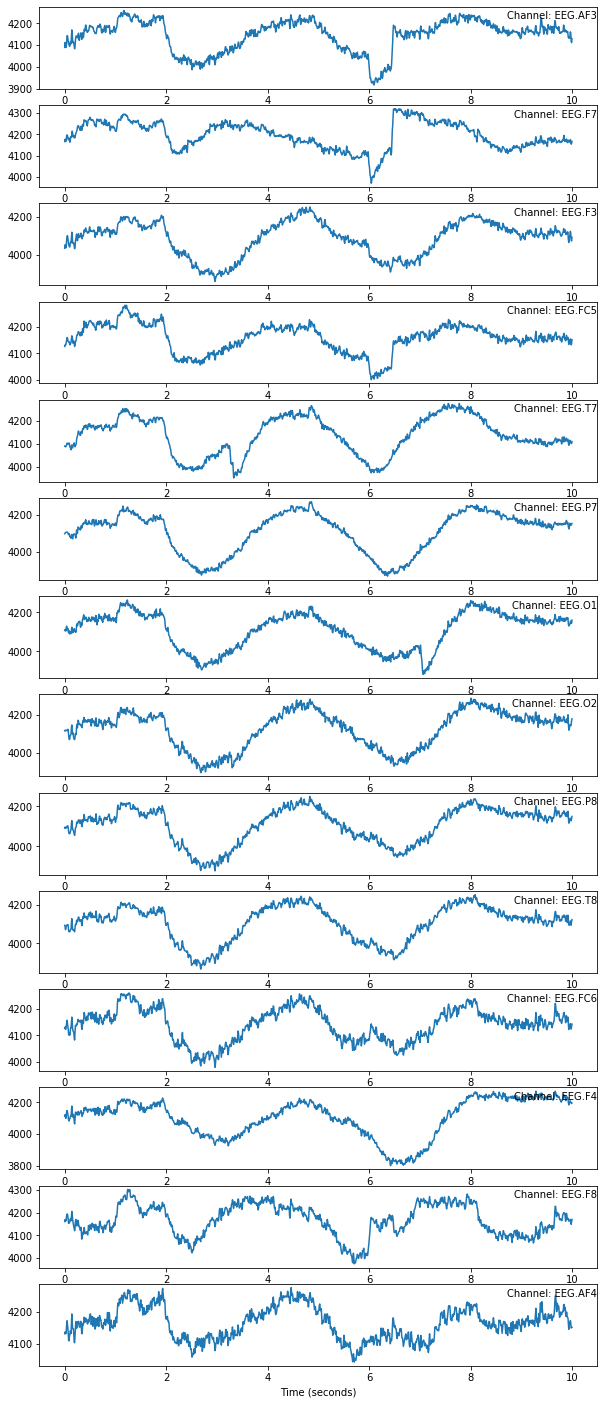

In [131]:
plot_raw(raw_open, cols=1, figsize=(10, 25), pos_x=1, pos_y=0.85)

#### Close

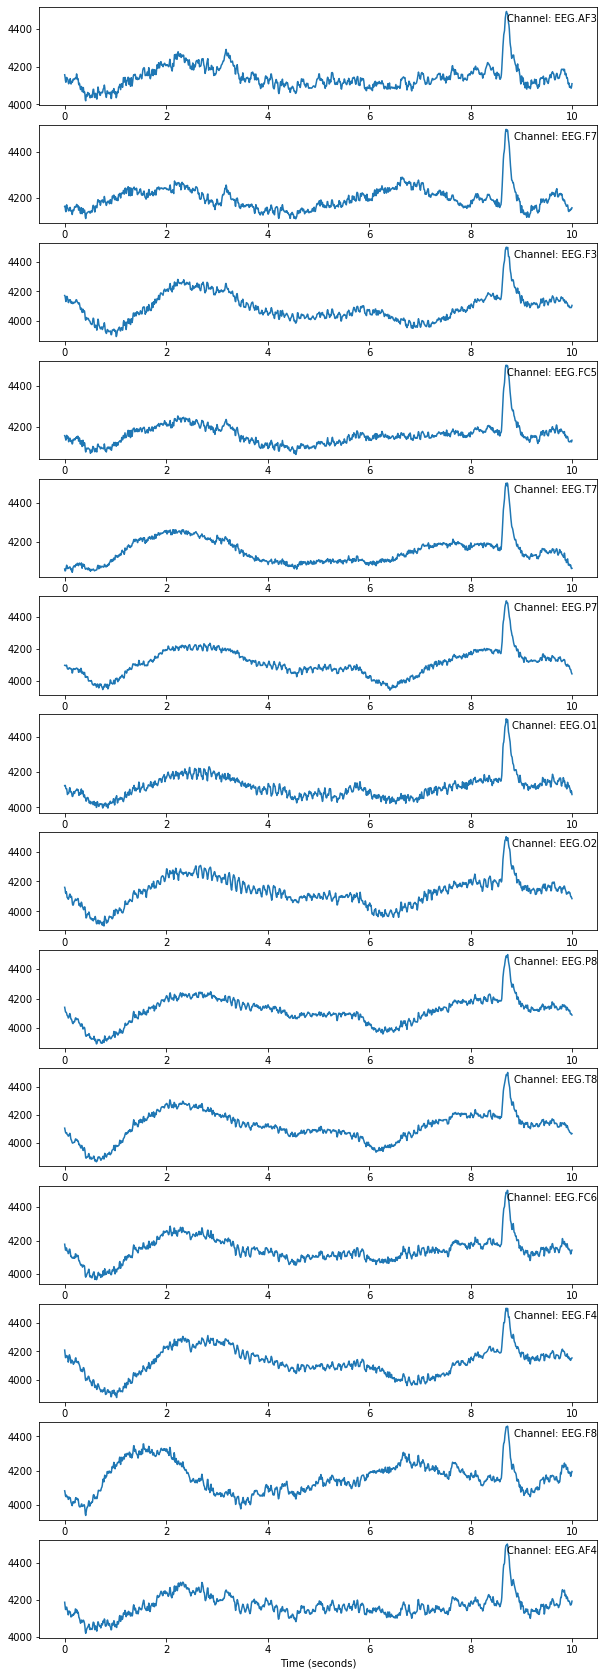

In [132]:
plot_raw(raw_close, cols=1, figsize=(10, 30), pos_x=1, pos_y=0.85)

### After baseline correction

#### Open

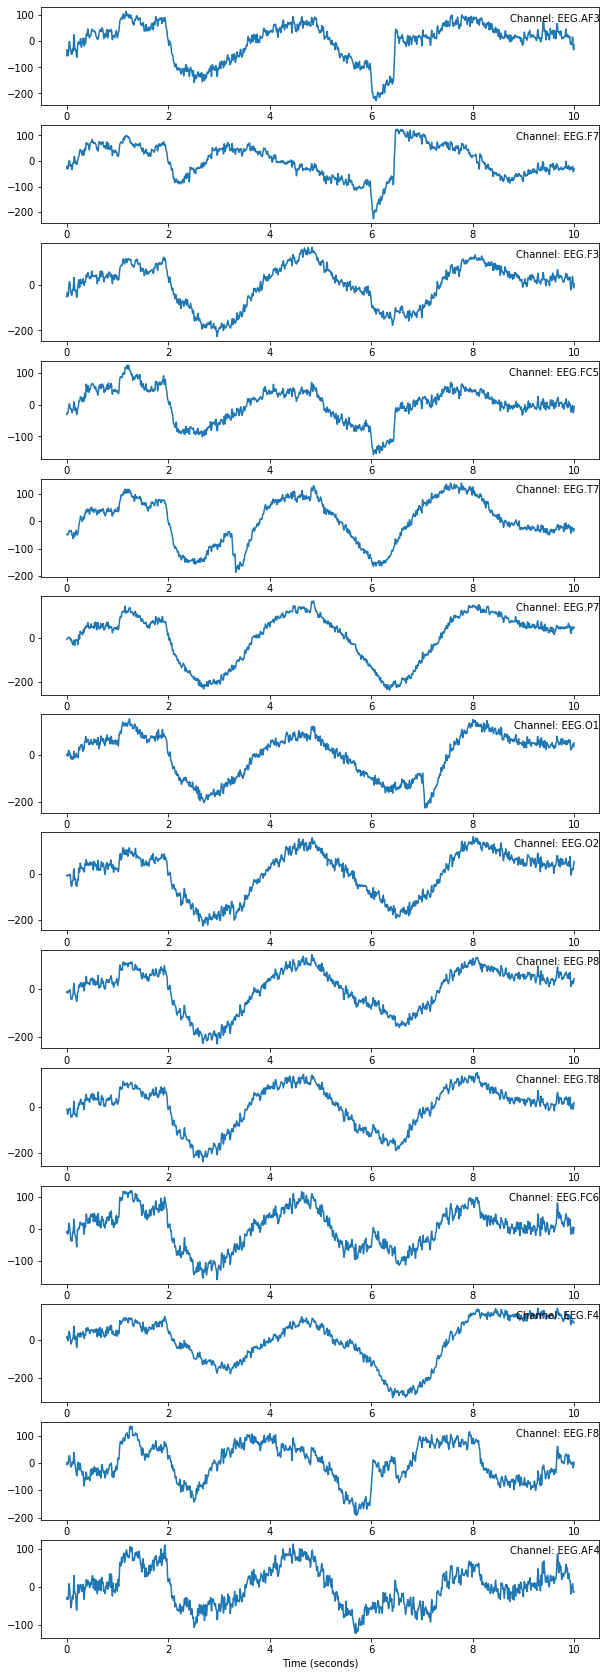

In [133]:
plot_raw(open_baseline_corrected, cols=1, figsize=(10, 30), pos_x=1, pos_y=0.85)

#### Close

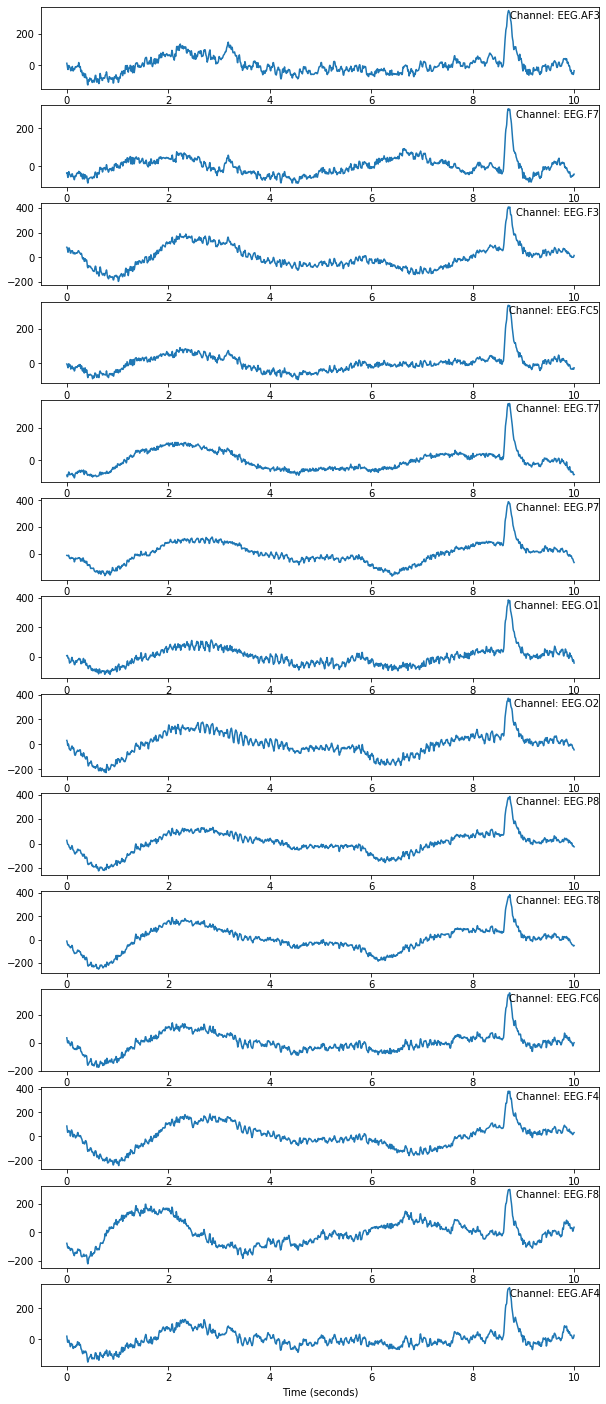

In [134]:
plot_raw(close_baseline_corrected, cols=1, figsize=(10, 25), pos_x=1, pos_y=0.85)

### After baseline correction + bandpass filter

#### Open

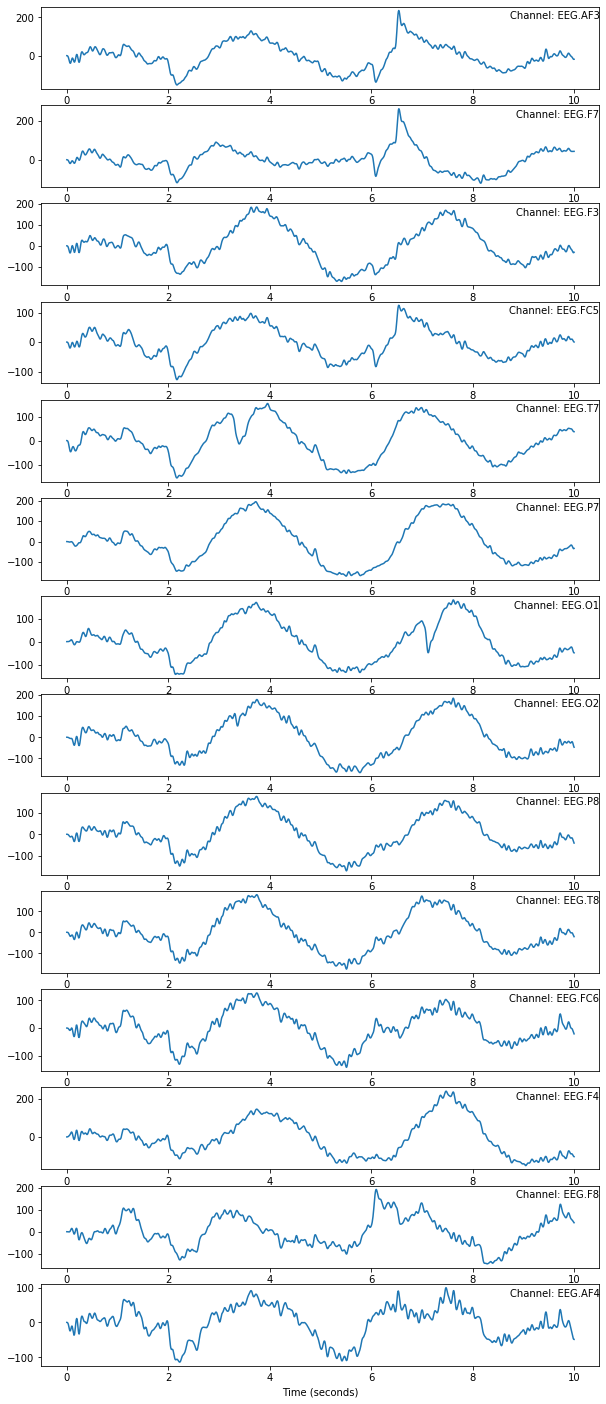

In [135]:
plot_raw(open_filtered, cols=1, figsize=(10, 25), pos_x=1, pos_y=0.85)

#### Close

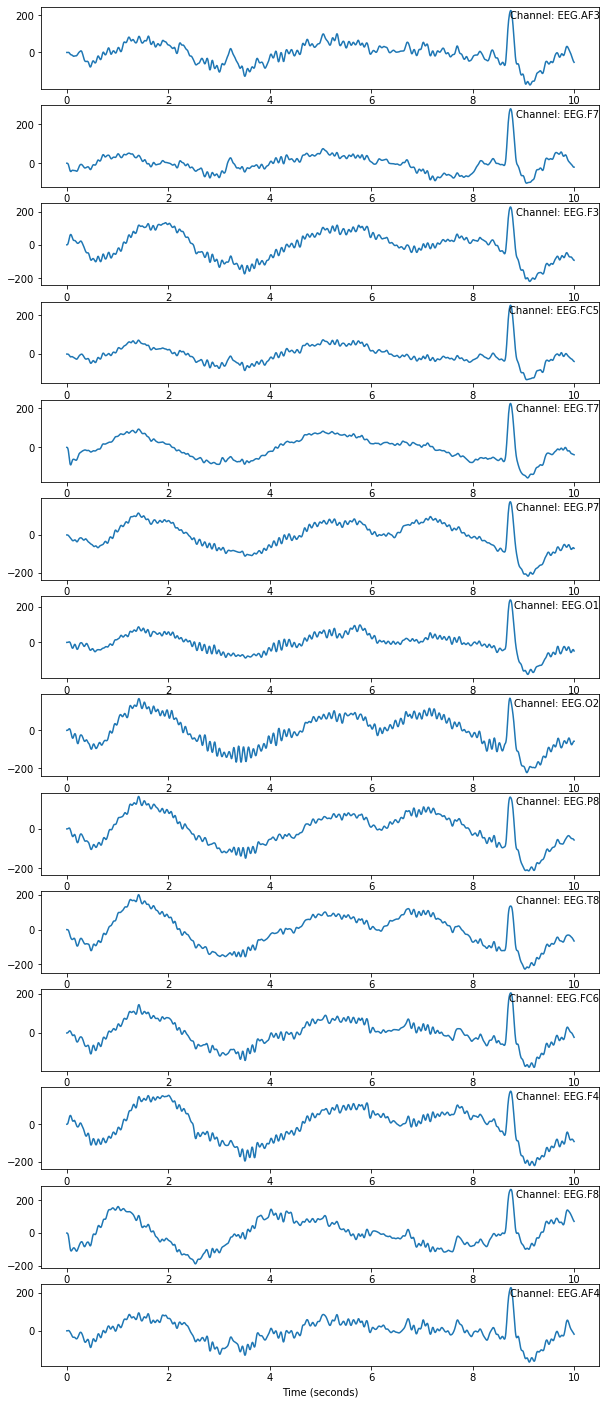

In [136]:
plot_raw(close_filtered, cols=1, figsize=(10, 25), pos_x=1, pos_y=0.85)

## PSD plots

### Raw

#### Open

CPU times: user 359 ms, sys: 1.96 ms, total: 361 ms
Wall time: 364 ms


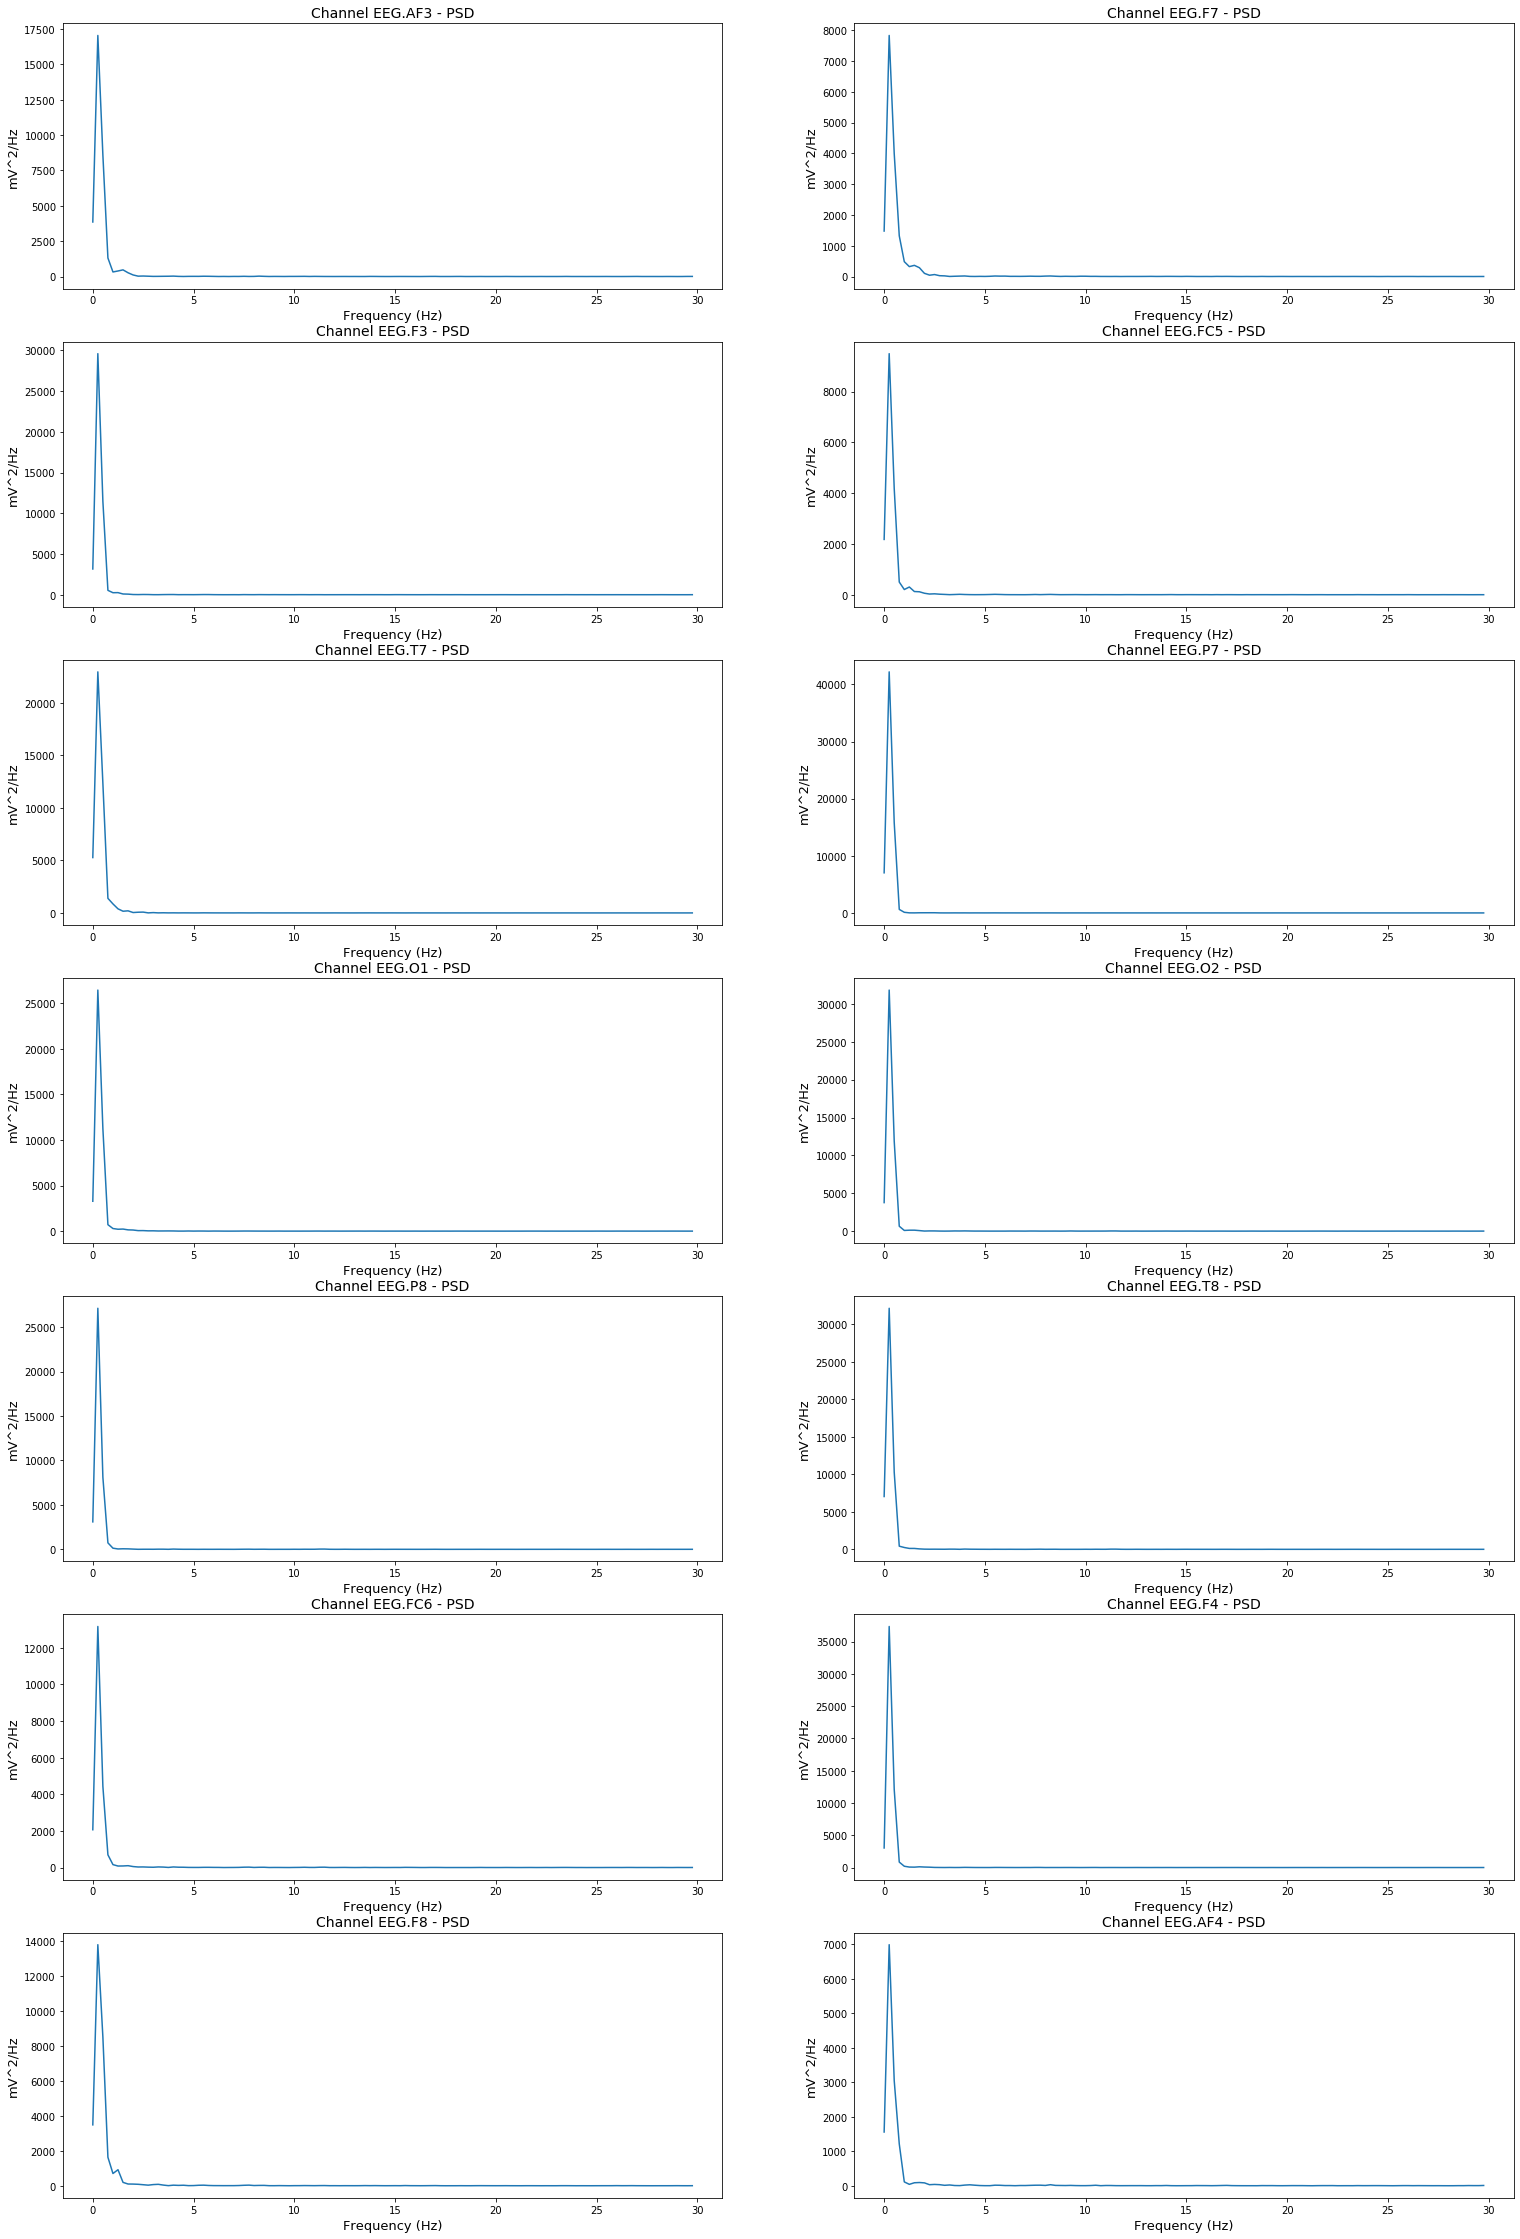

In [137]:
%%time
plot_psd(raw_open, cols=2, max_f=30, figsize=(26,40), unit="mV^2/Hz")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning:

invalid value encountered in true_divide



CPU times: user 327 ms, sys: 2.94 ms, total: 330 ms
Wall time: 336 ms


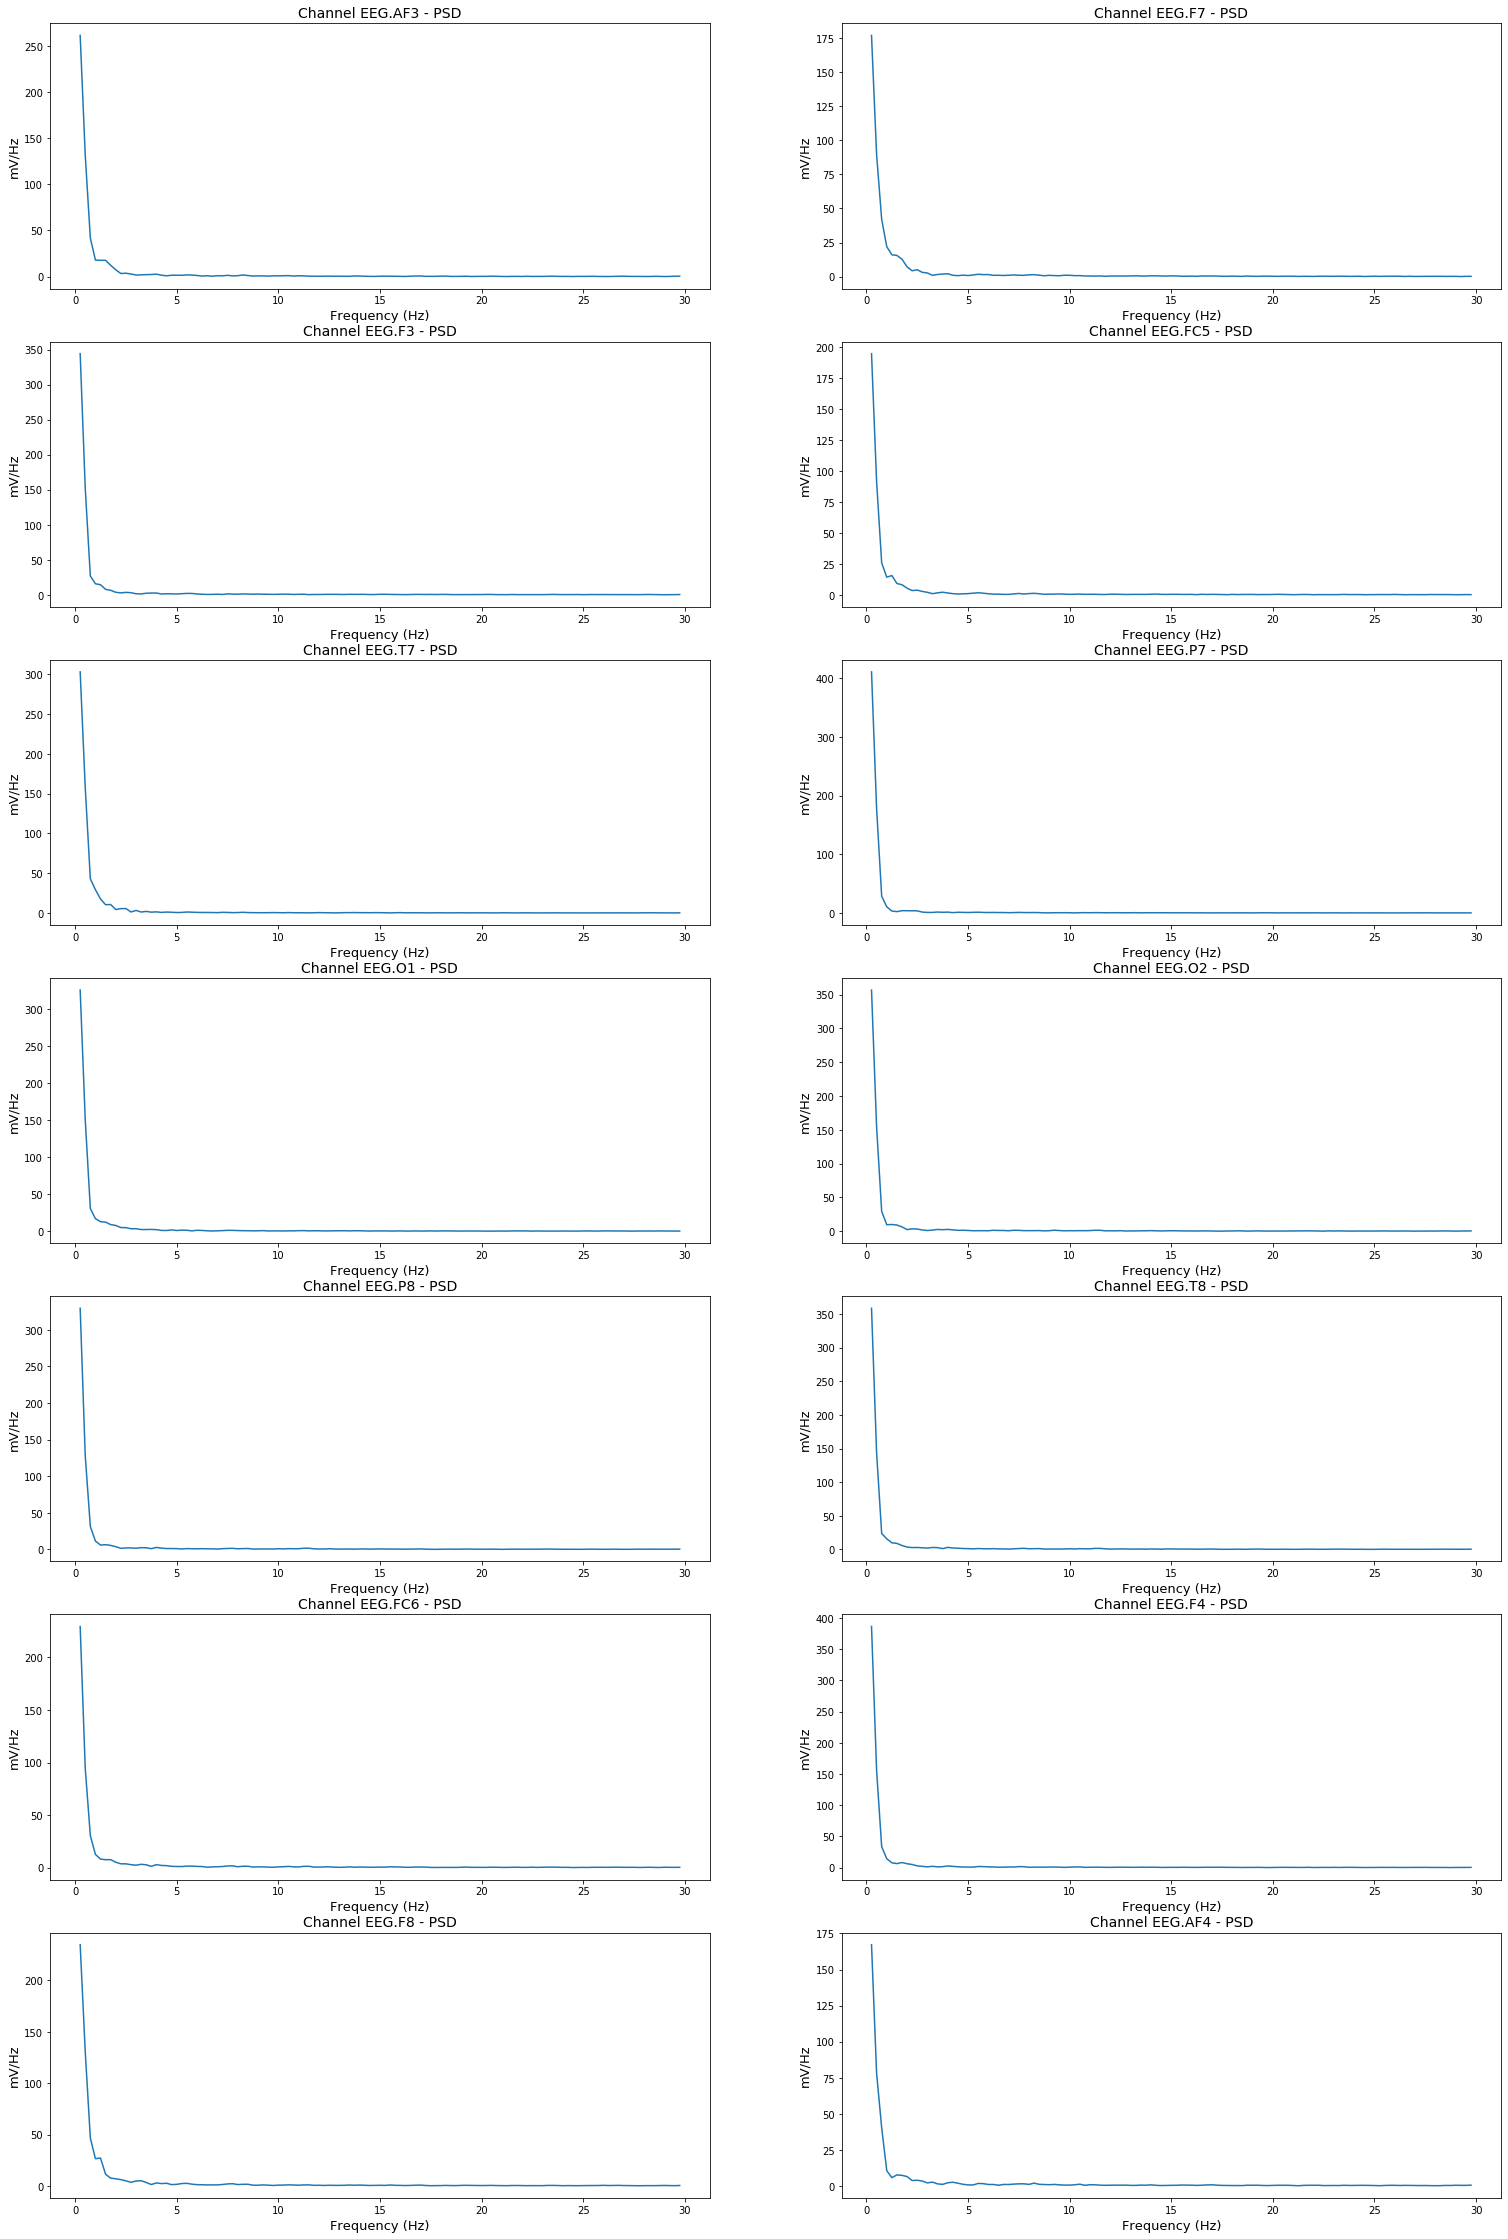

In [138]:
%%time
plot_psd(raw_open, cols=2, max_f=30, figsize=(26,40), unit="mV/Hz")

#### Close

CPU times: user 270 ms, sys: 1.99 ms, total: 272 ms
Wall time: 275 ms


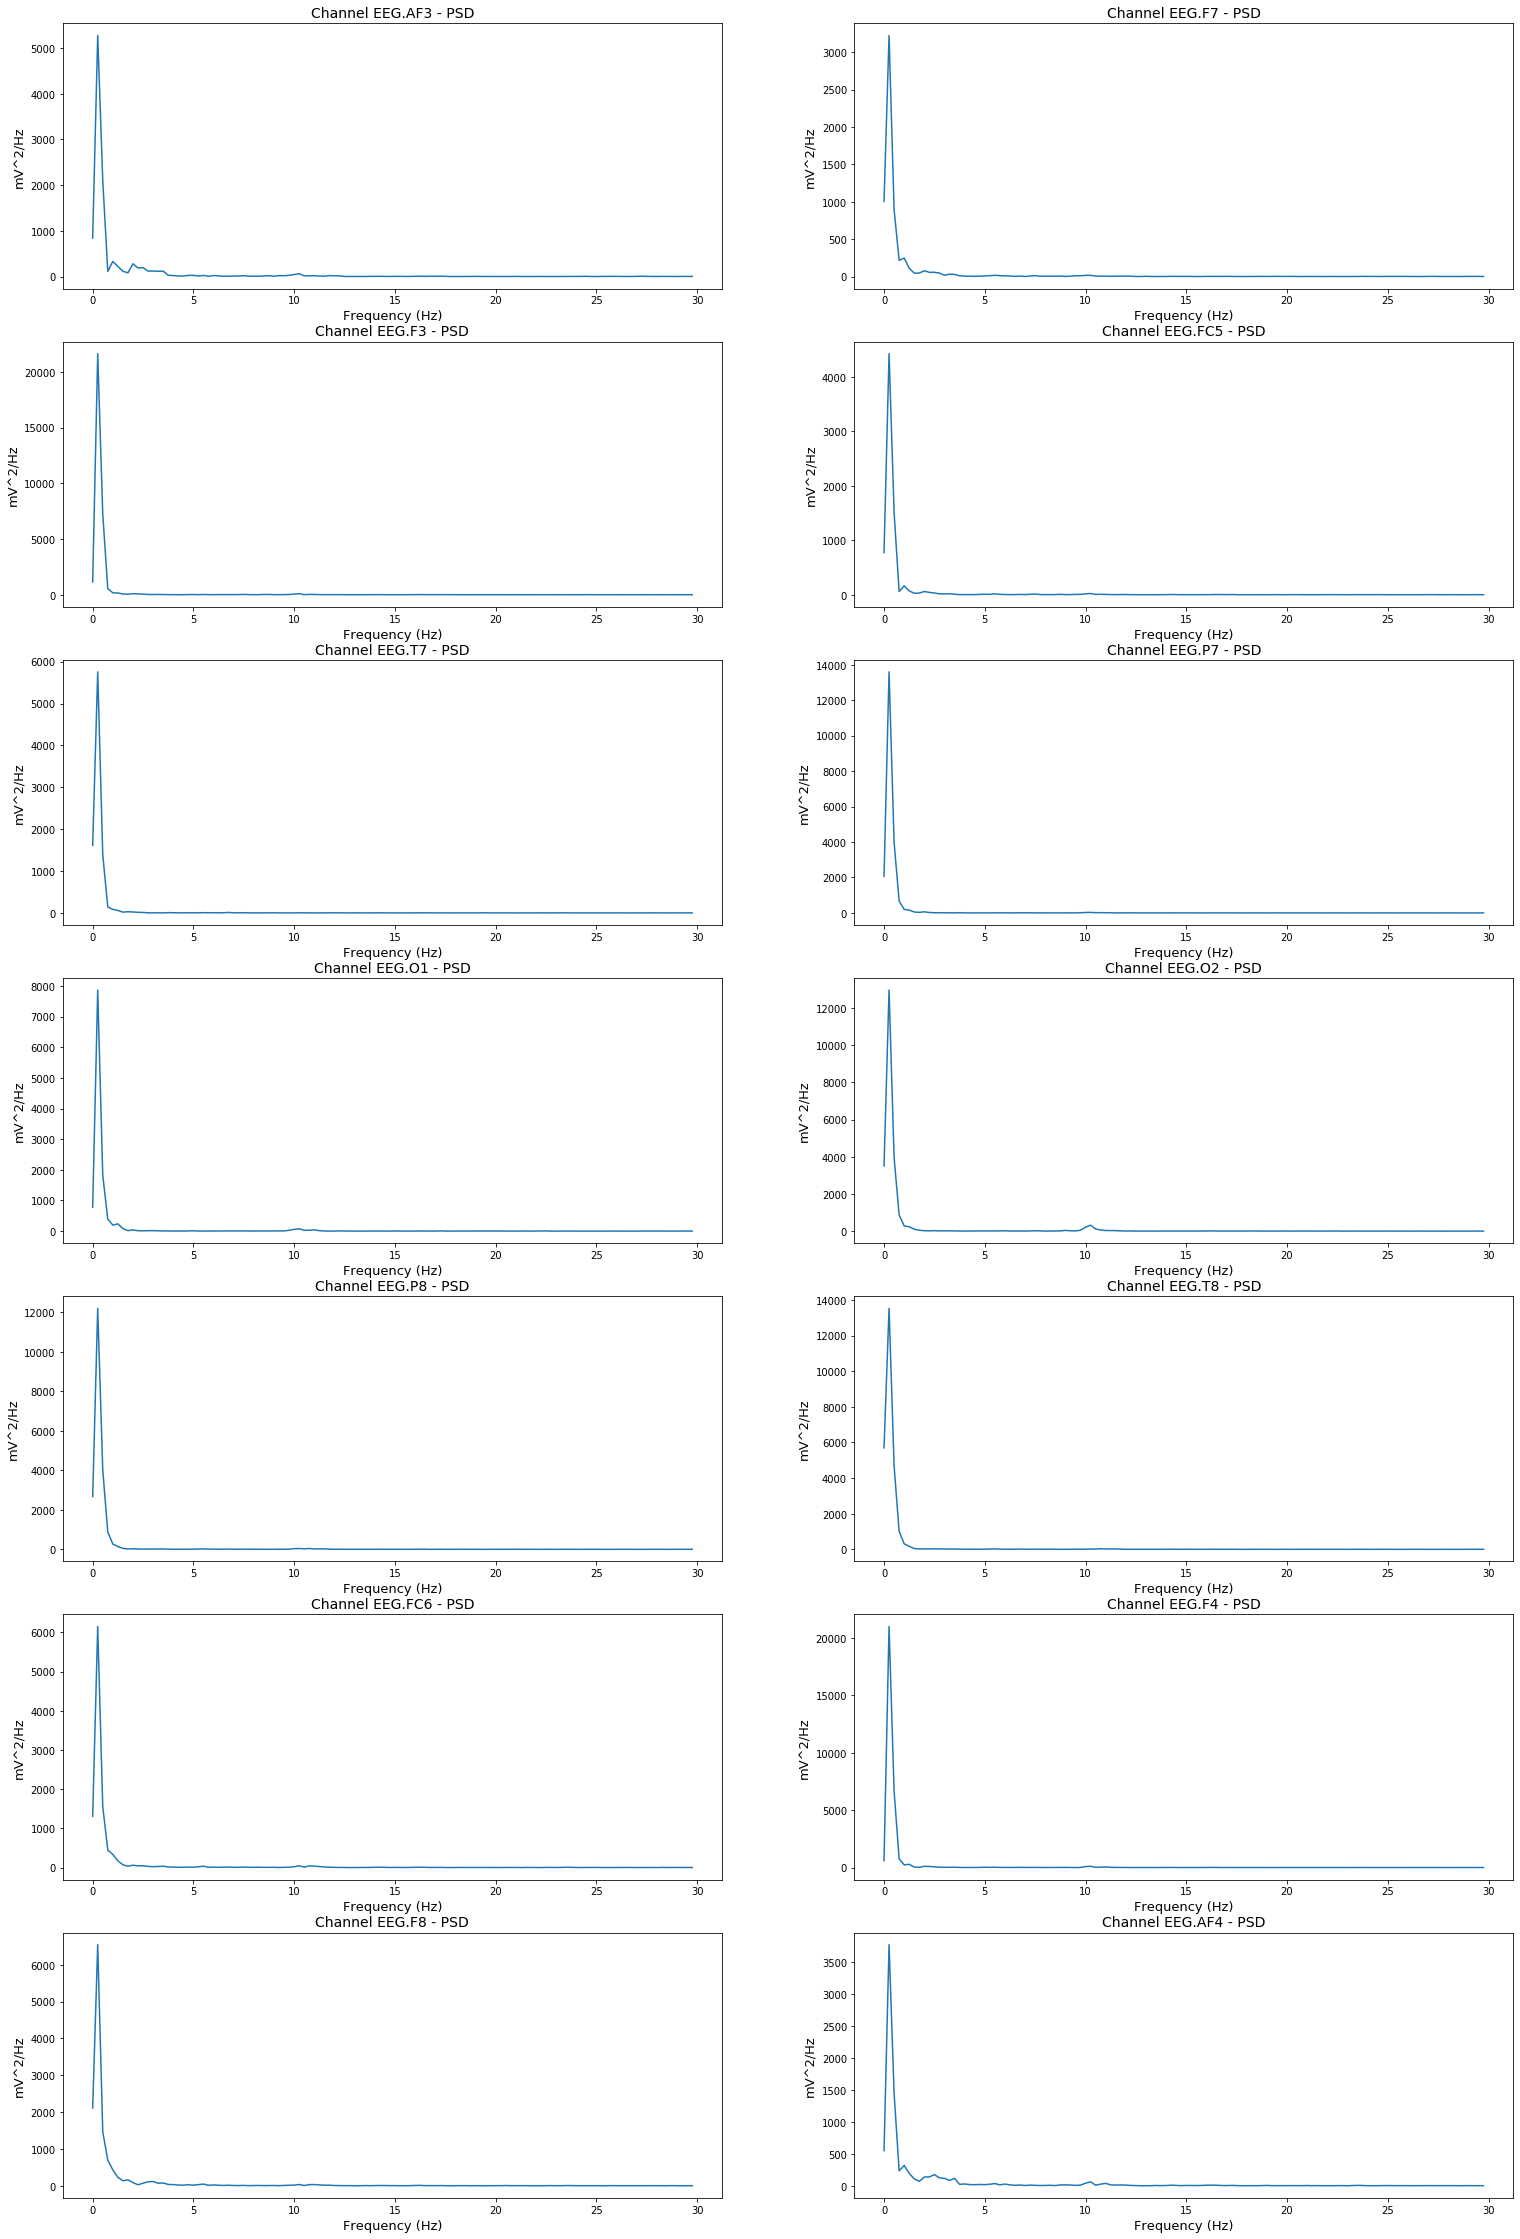

In [139]:
%%time
plot_psd(raw_close, cols=2, max_f=30, figsize=(26,40), unit="mV^2/Hz")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning:

invalid value encountered in true_divide



CPU times: user 257 ms, sys: 979 µs, total: 258 ms
Wall time: 259 ms


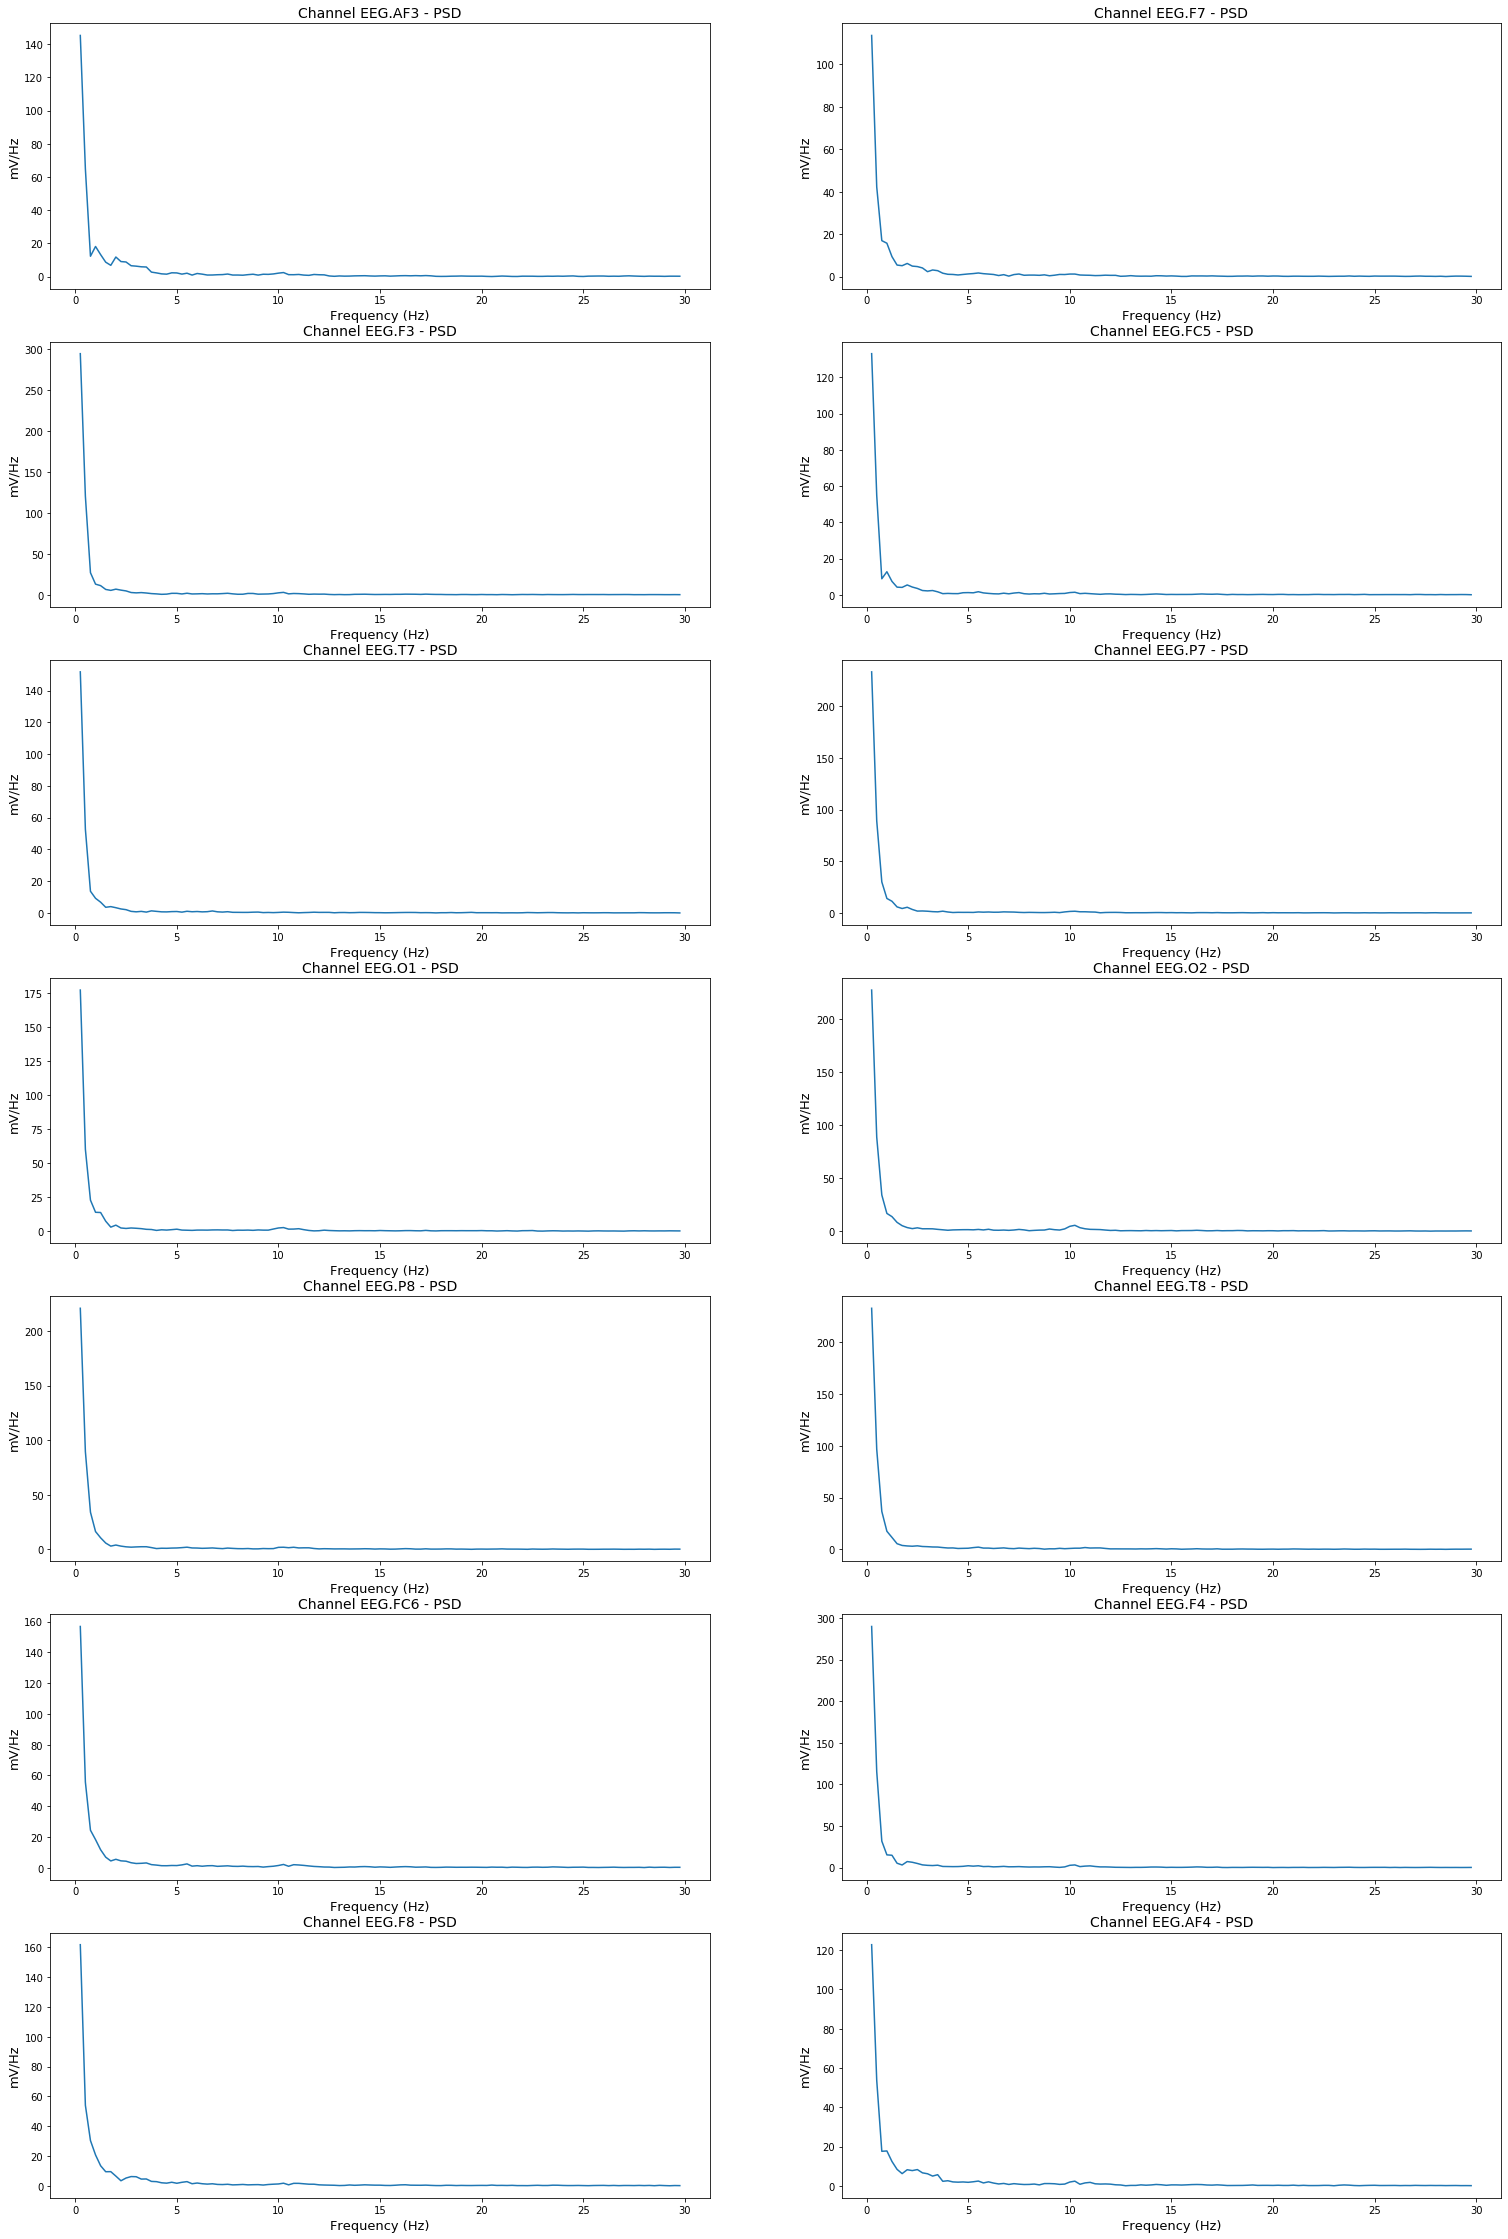

In [140]:
%%time
plot_psd(raw_close, cols=2, max_f=30, figsize=(26,40), unit="mV/Hz")

### After baseline correction

#### Open

CPU times: user 224 ms, sys: 1.91 ms, total: 226 ms
Wall time: 229 ms


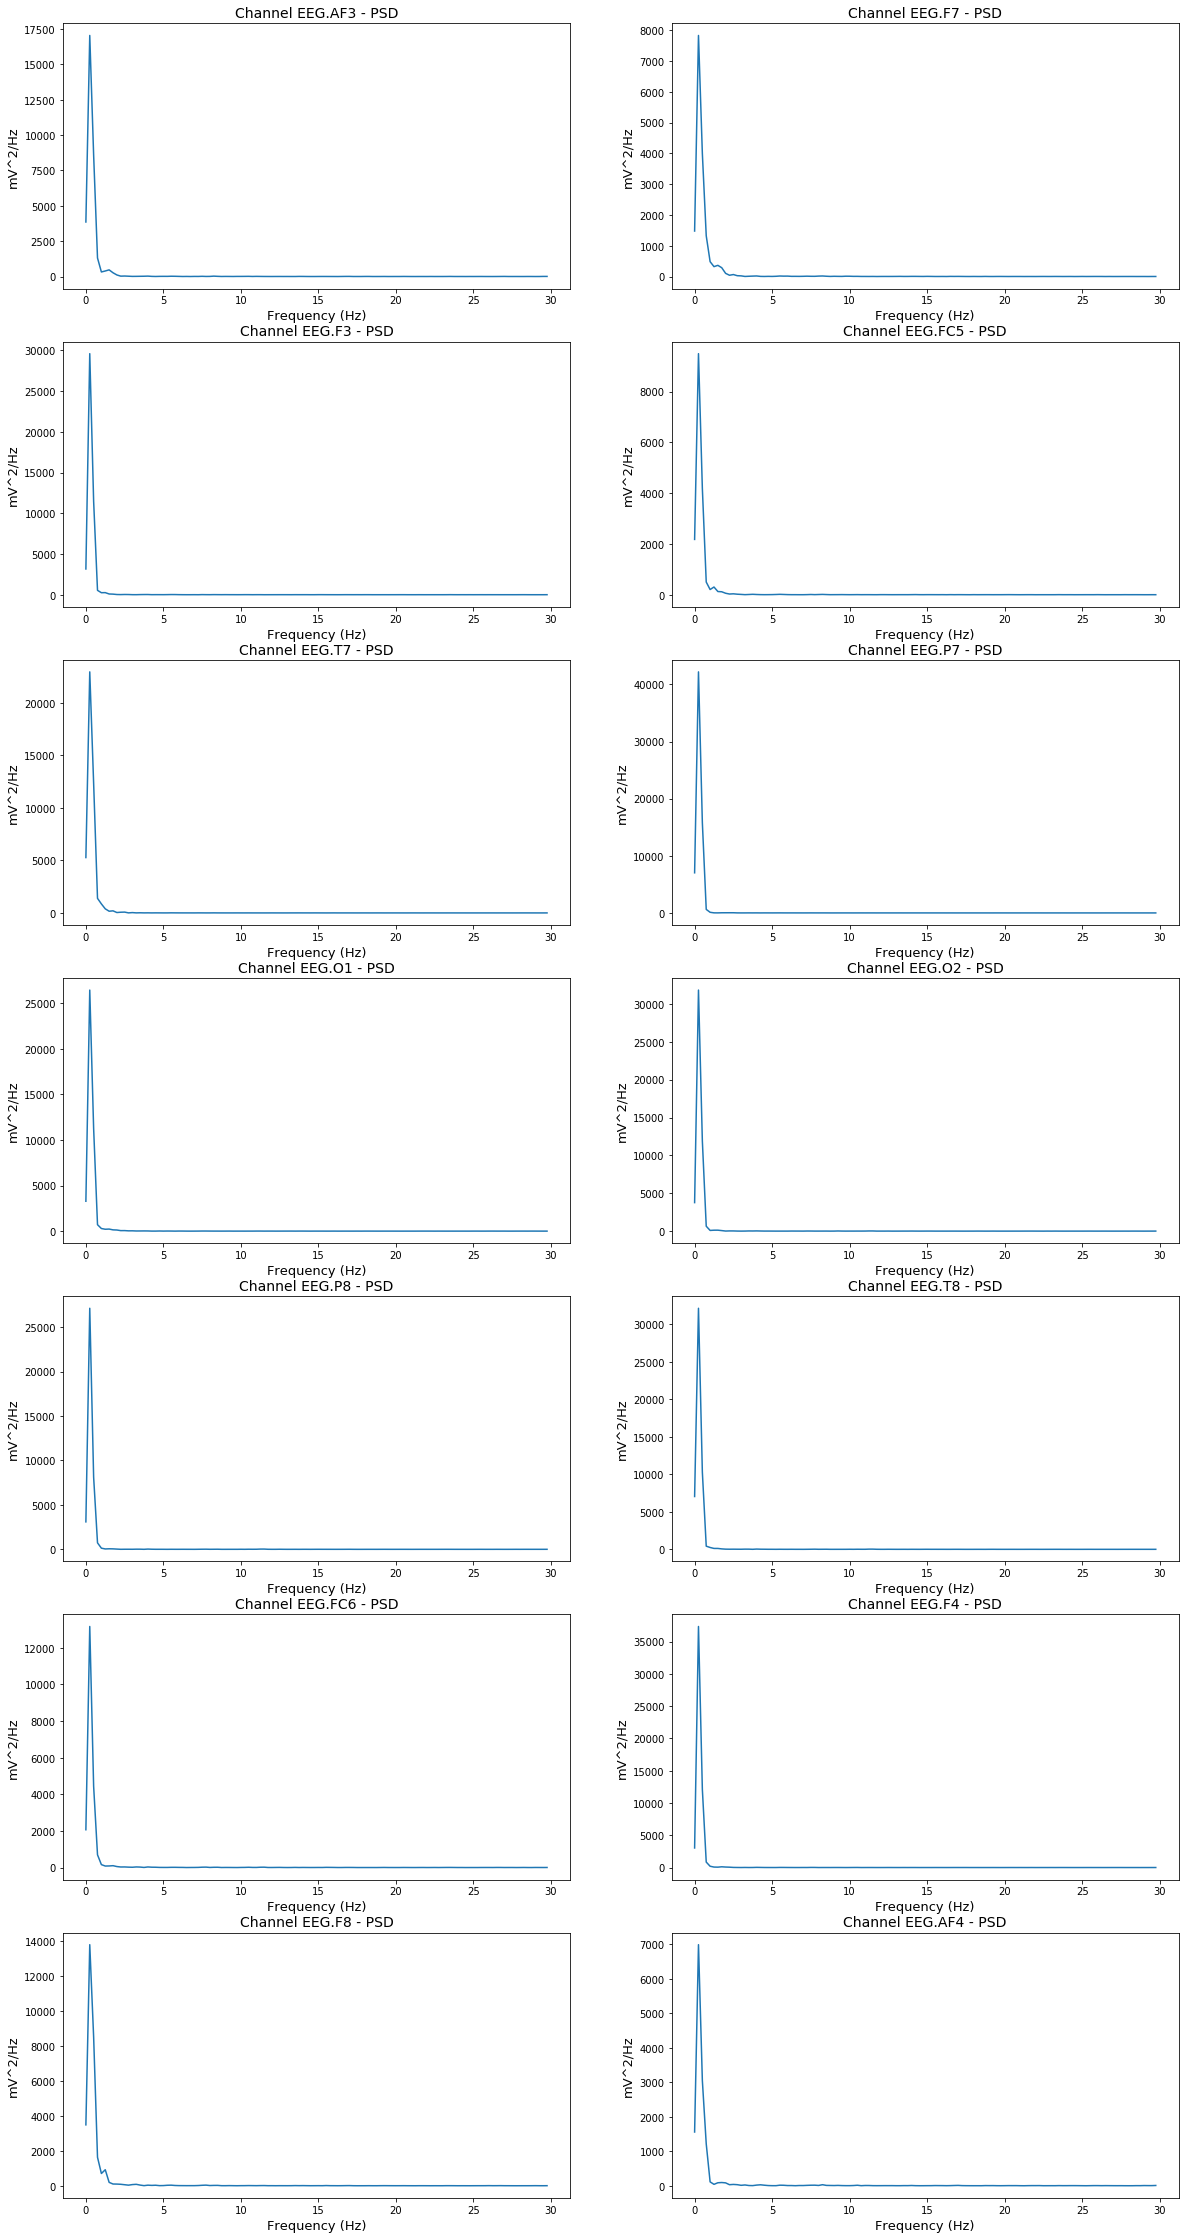

In [141]:
%%time
plot_psd(open_baseline_corrected, cols=2, max_f=30, figsize=(20,40), unit="mV^2/Hz")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning:

invalid value encountered in true_divide



CPU times: user 225 ms, sys: 1.95 ms, total: 227 ms
Wall time: 227 ms


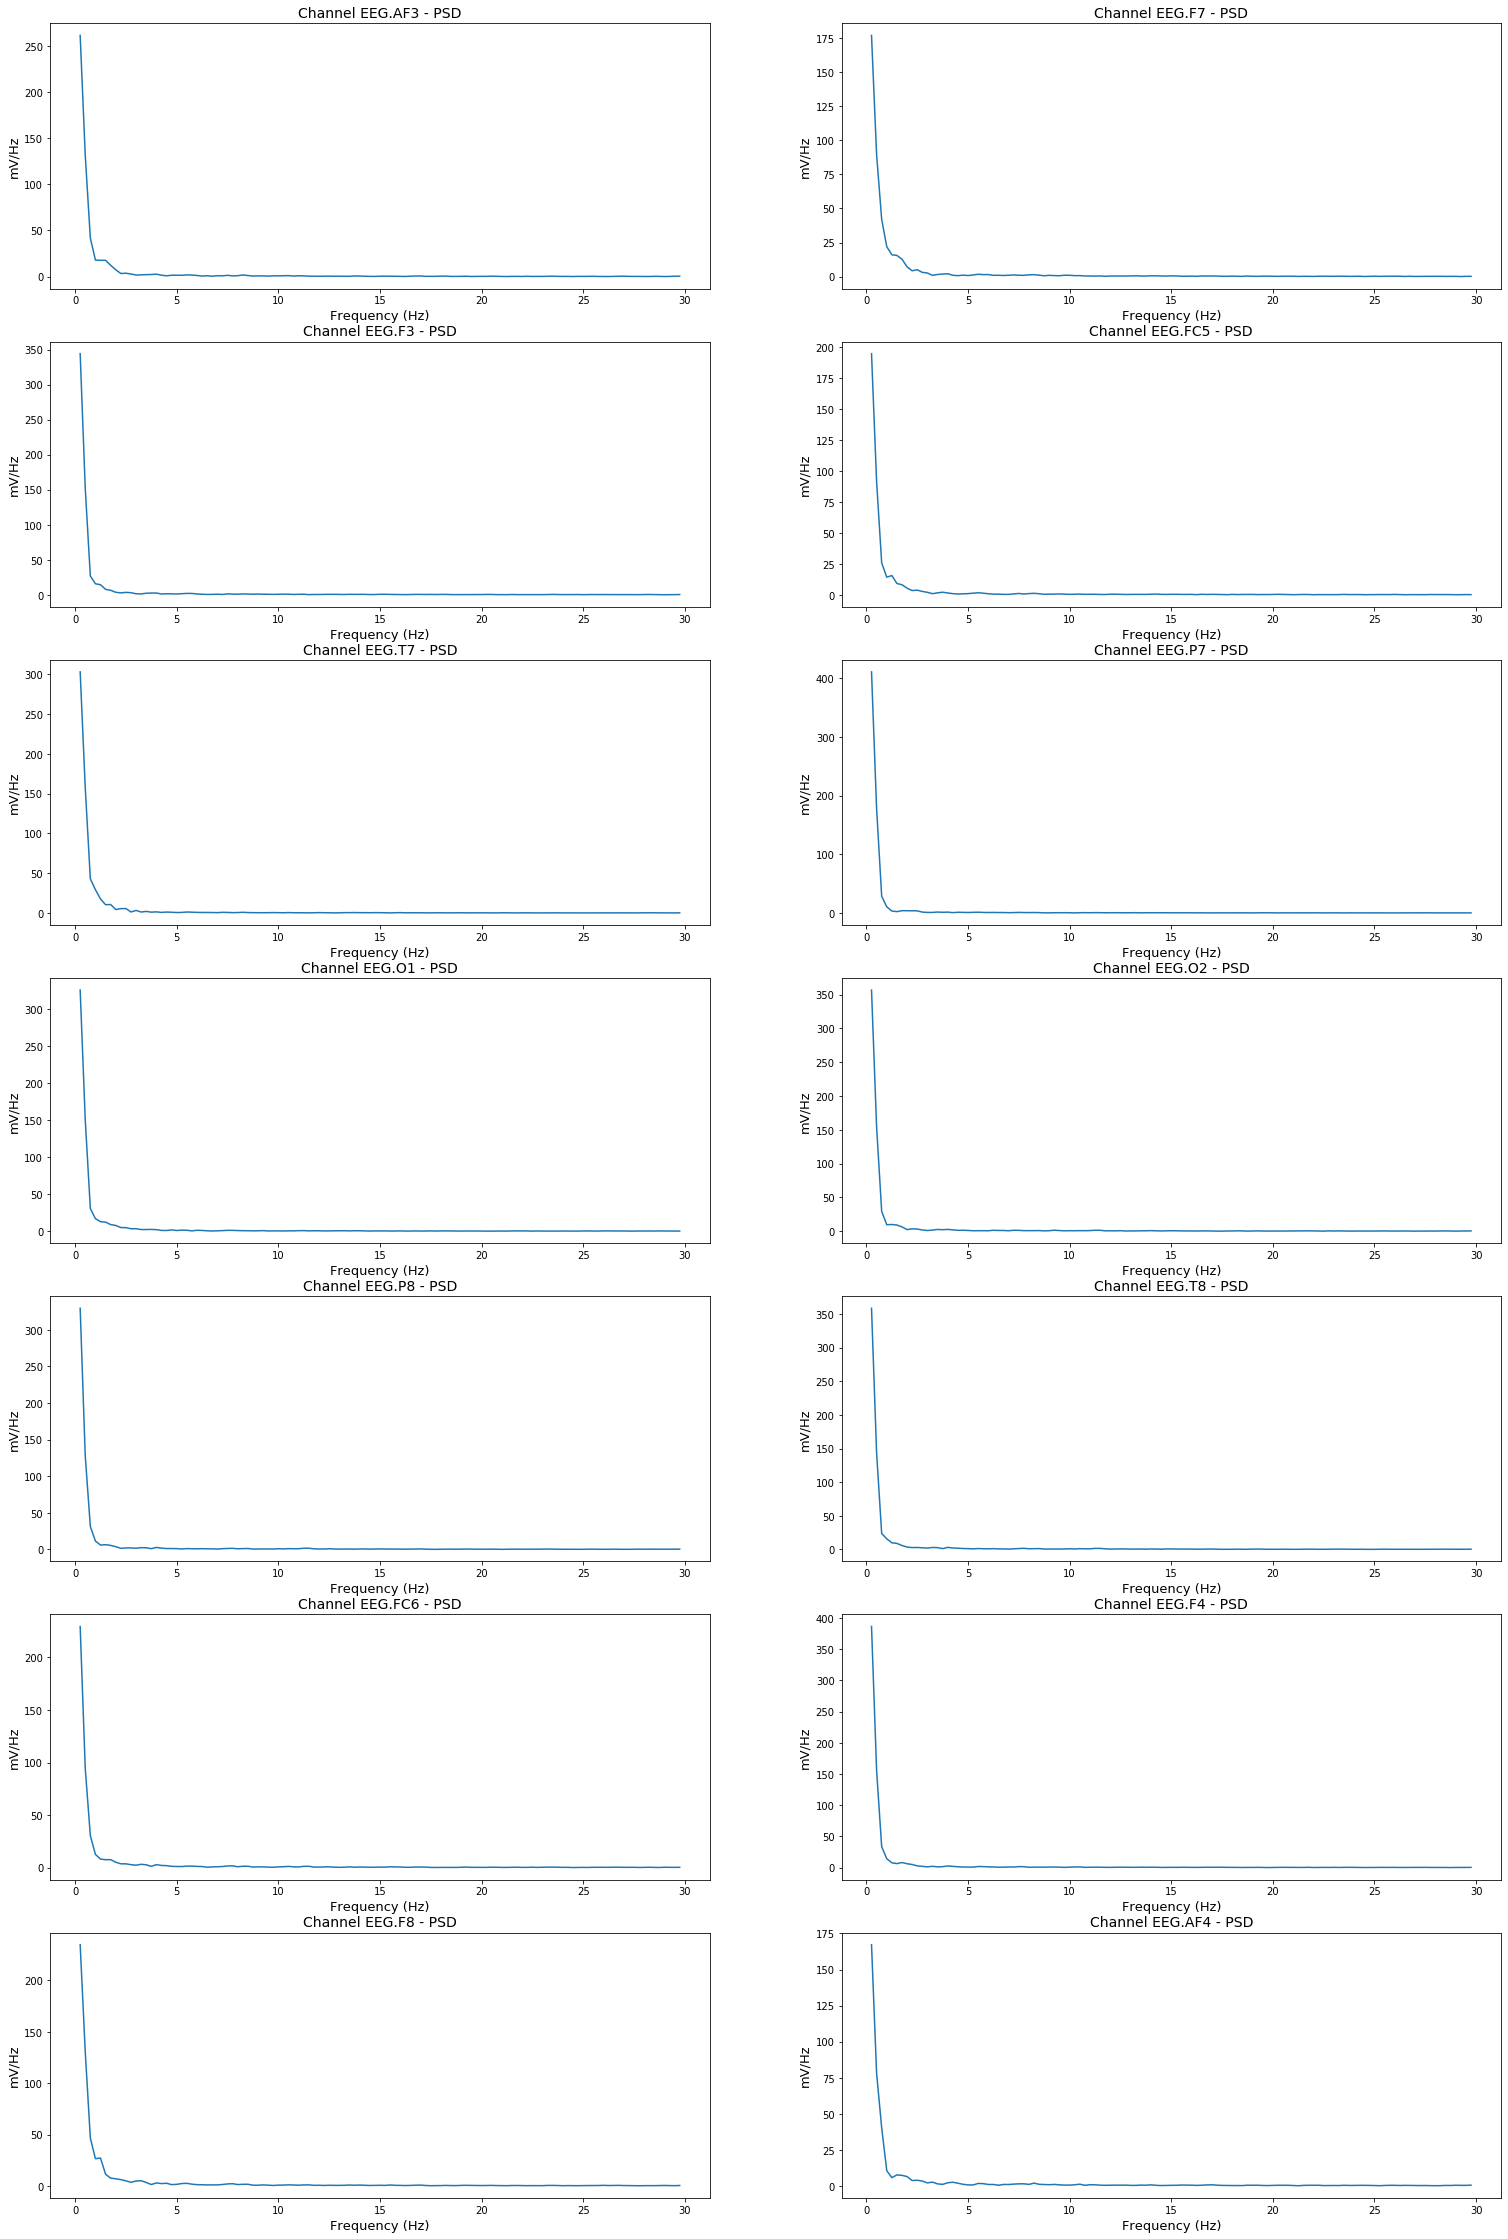

In [142]:
%%time
plot_psd(open_baseline_corrected, cols=2, max_f=30, figsize=(26,40), unit="mV/Hz")

#### Close

CPU times: user 240 ms, sys: 992 µs, total: 241 ms
Wall time: 241 ms


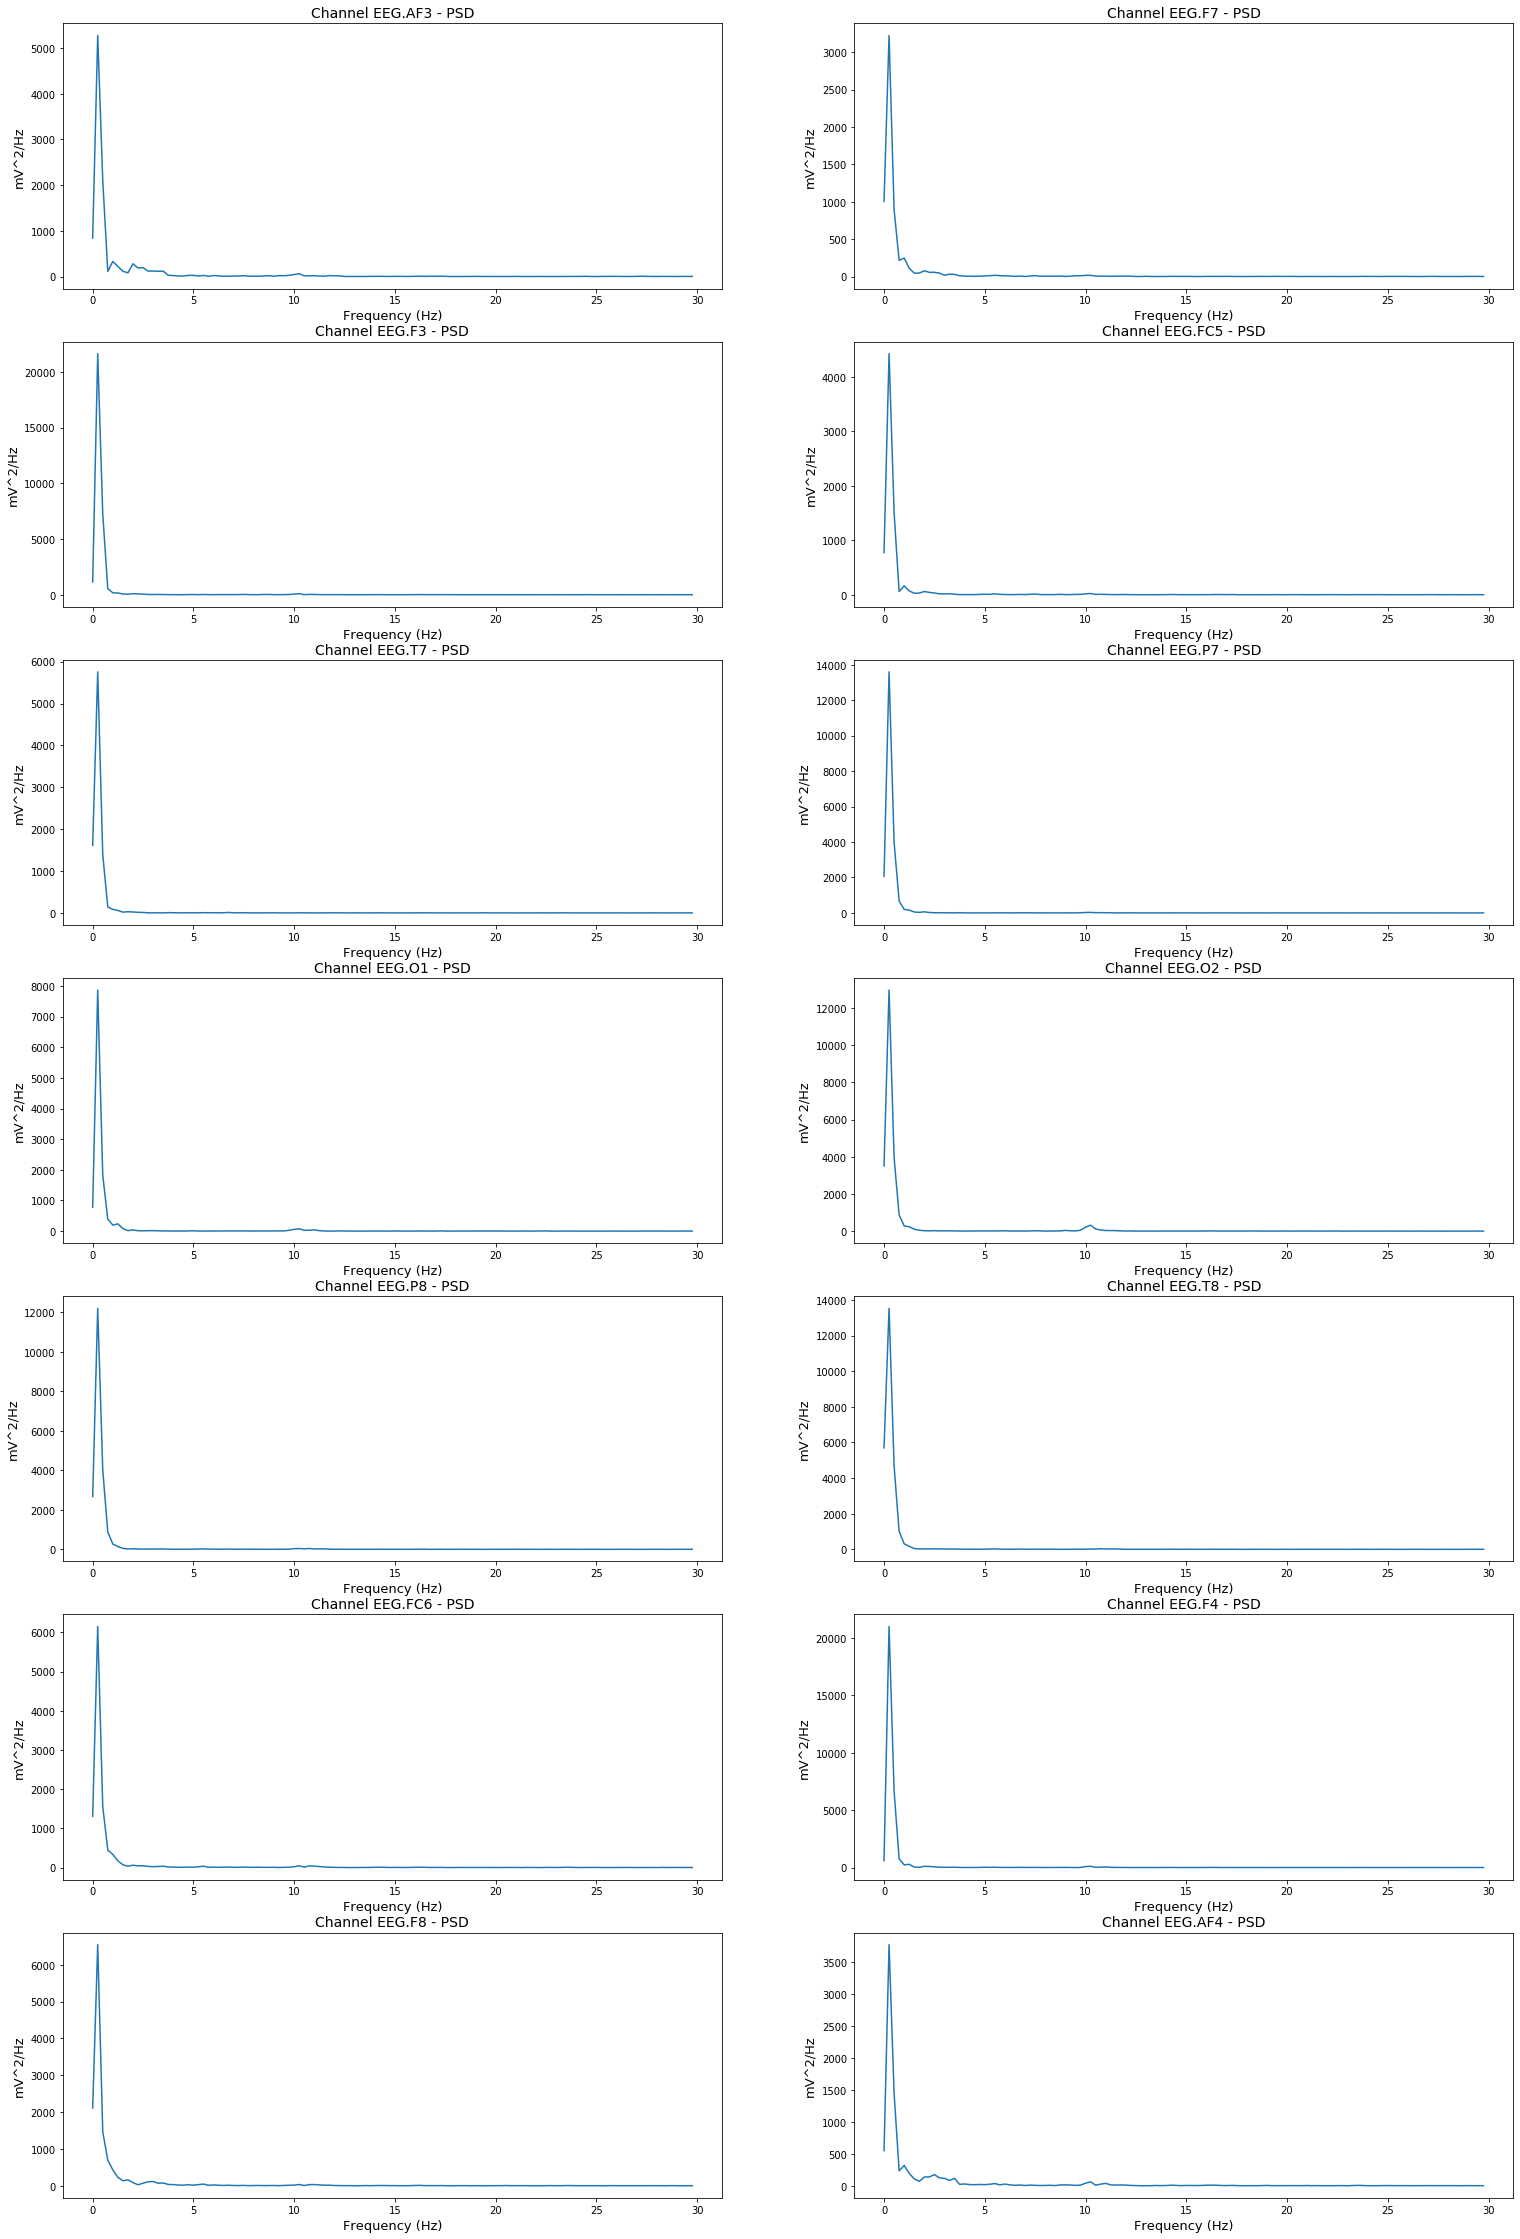

In [143]:
%%time
plot_psd(close_baseline_corrected, cols=2, max_f=30, figsize=(26,40), unit="mV^2/Hz")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning:

invalid value encountered in true_divide



CPU times: user 224 ms, sys: 3.98 ms, total: 228 ms
Wall time: 229 ms


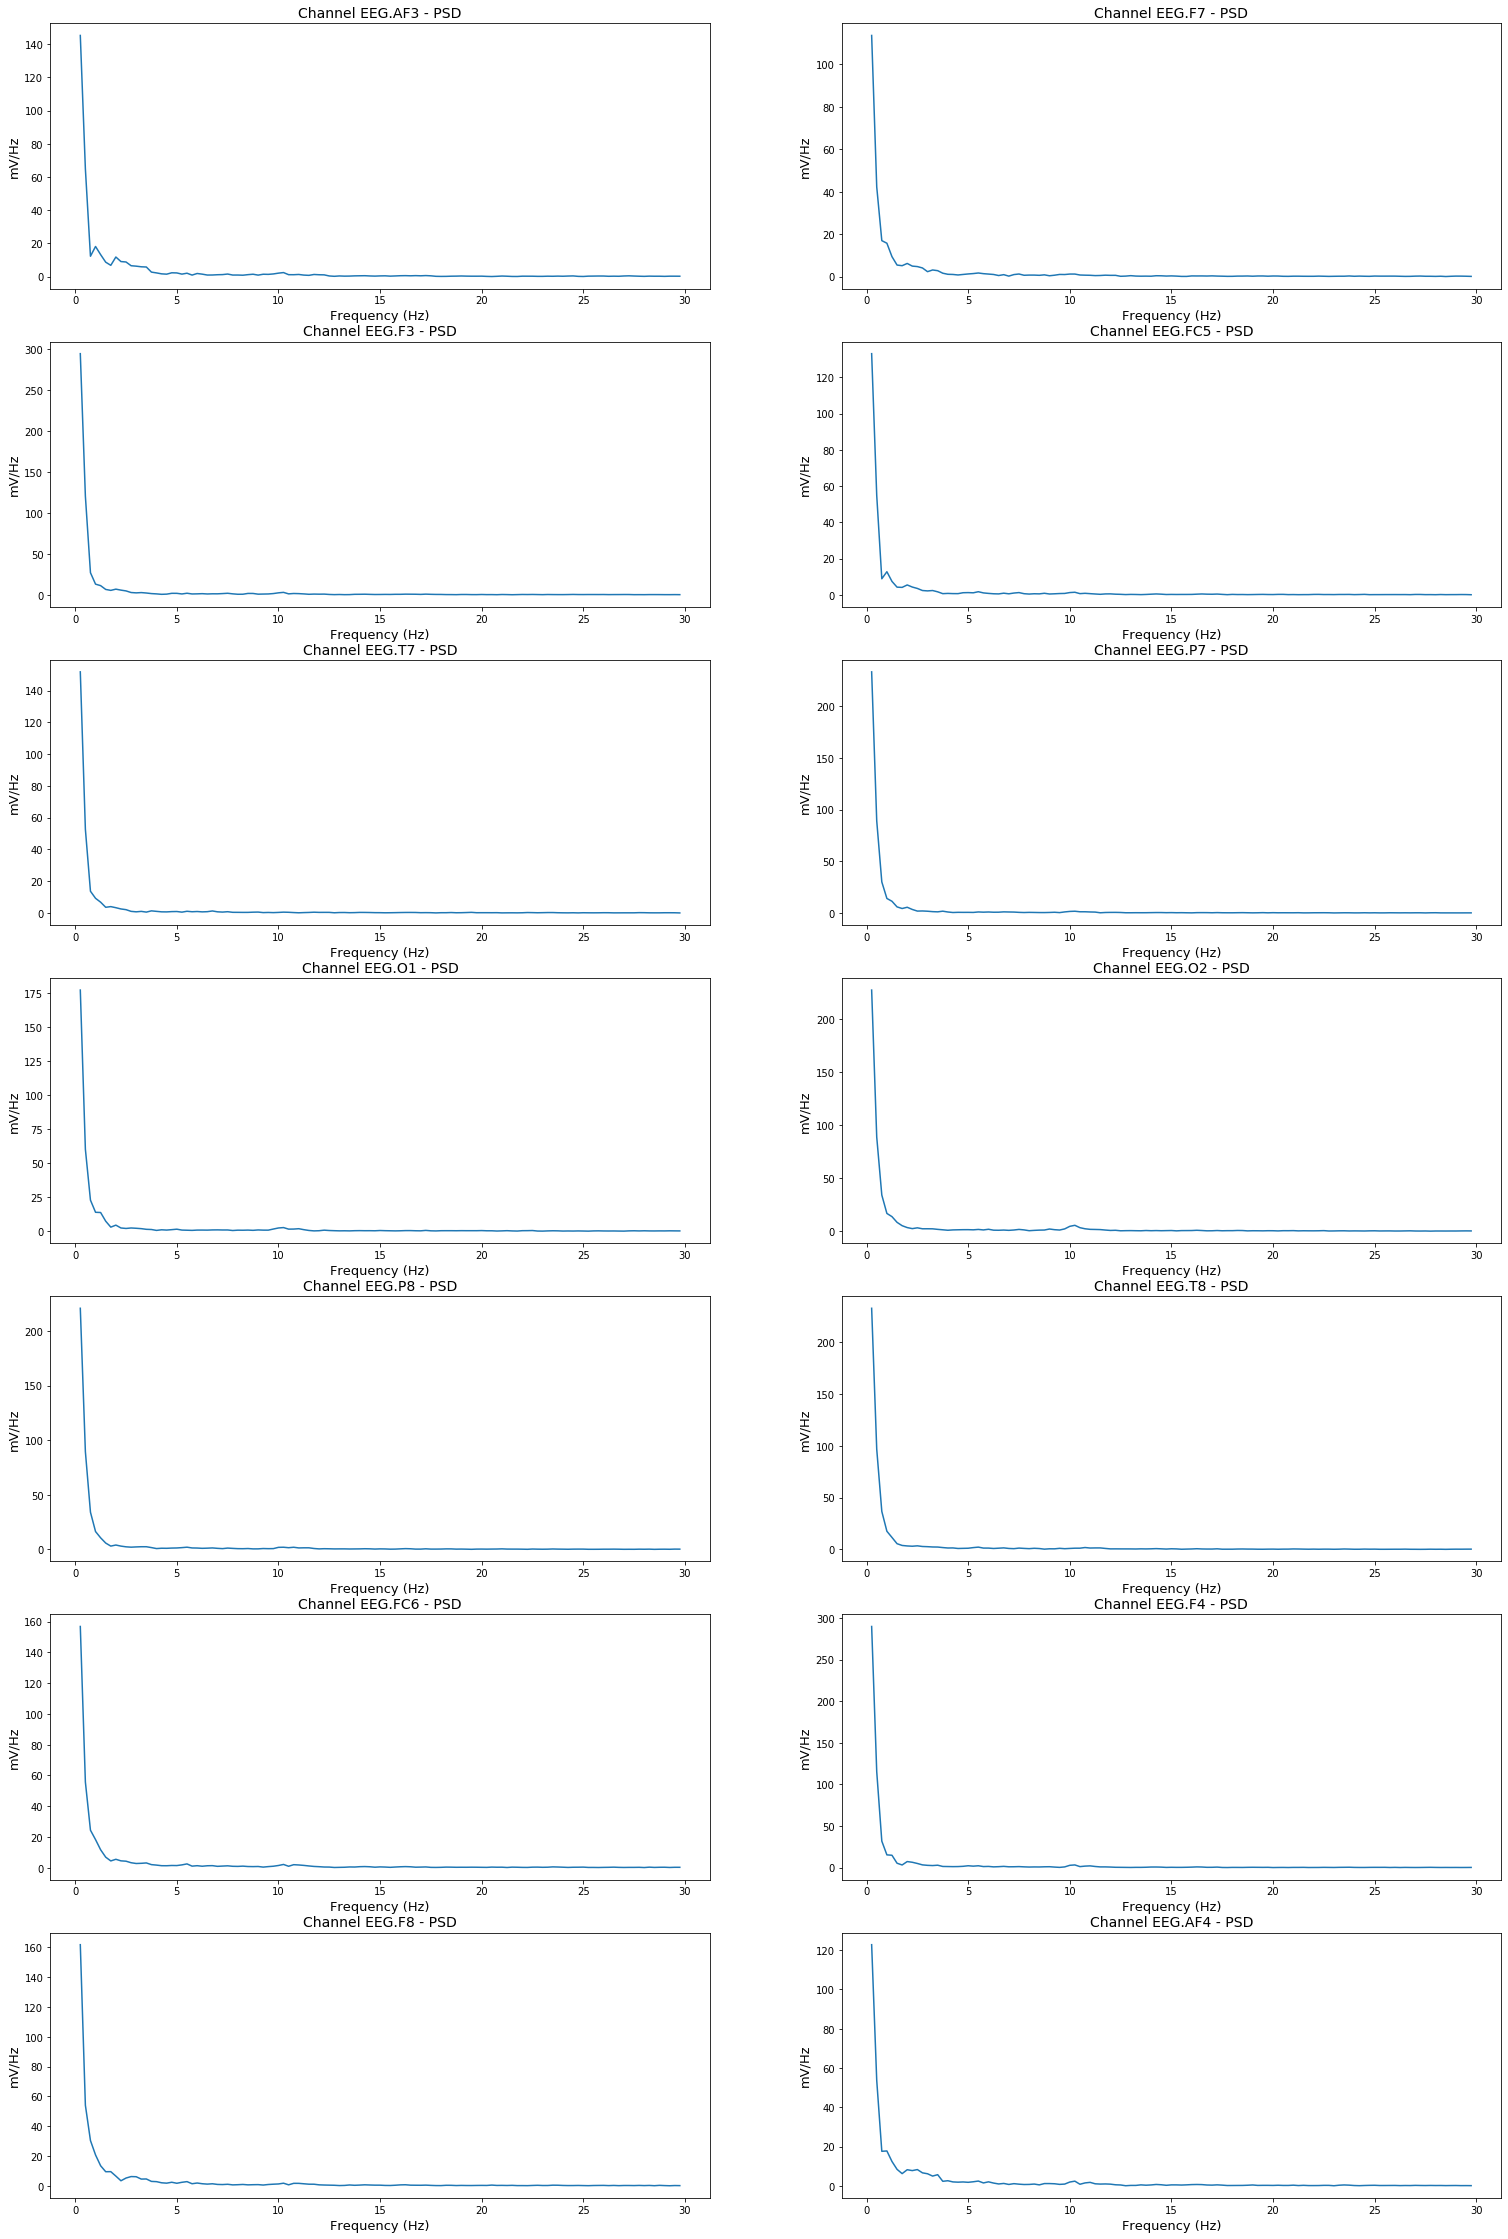

In [144]:
%%time
plot_psd(close_baseline_corrected, cols=2, max_f=30, figsize=(26,40), unit="mV/Hz")

### After baseline correction + bandpass filter

#### Open

CPU times: user 227 ms, sys: 9 µs, total: 227 ms
Wall time: 228 ms


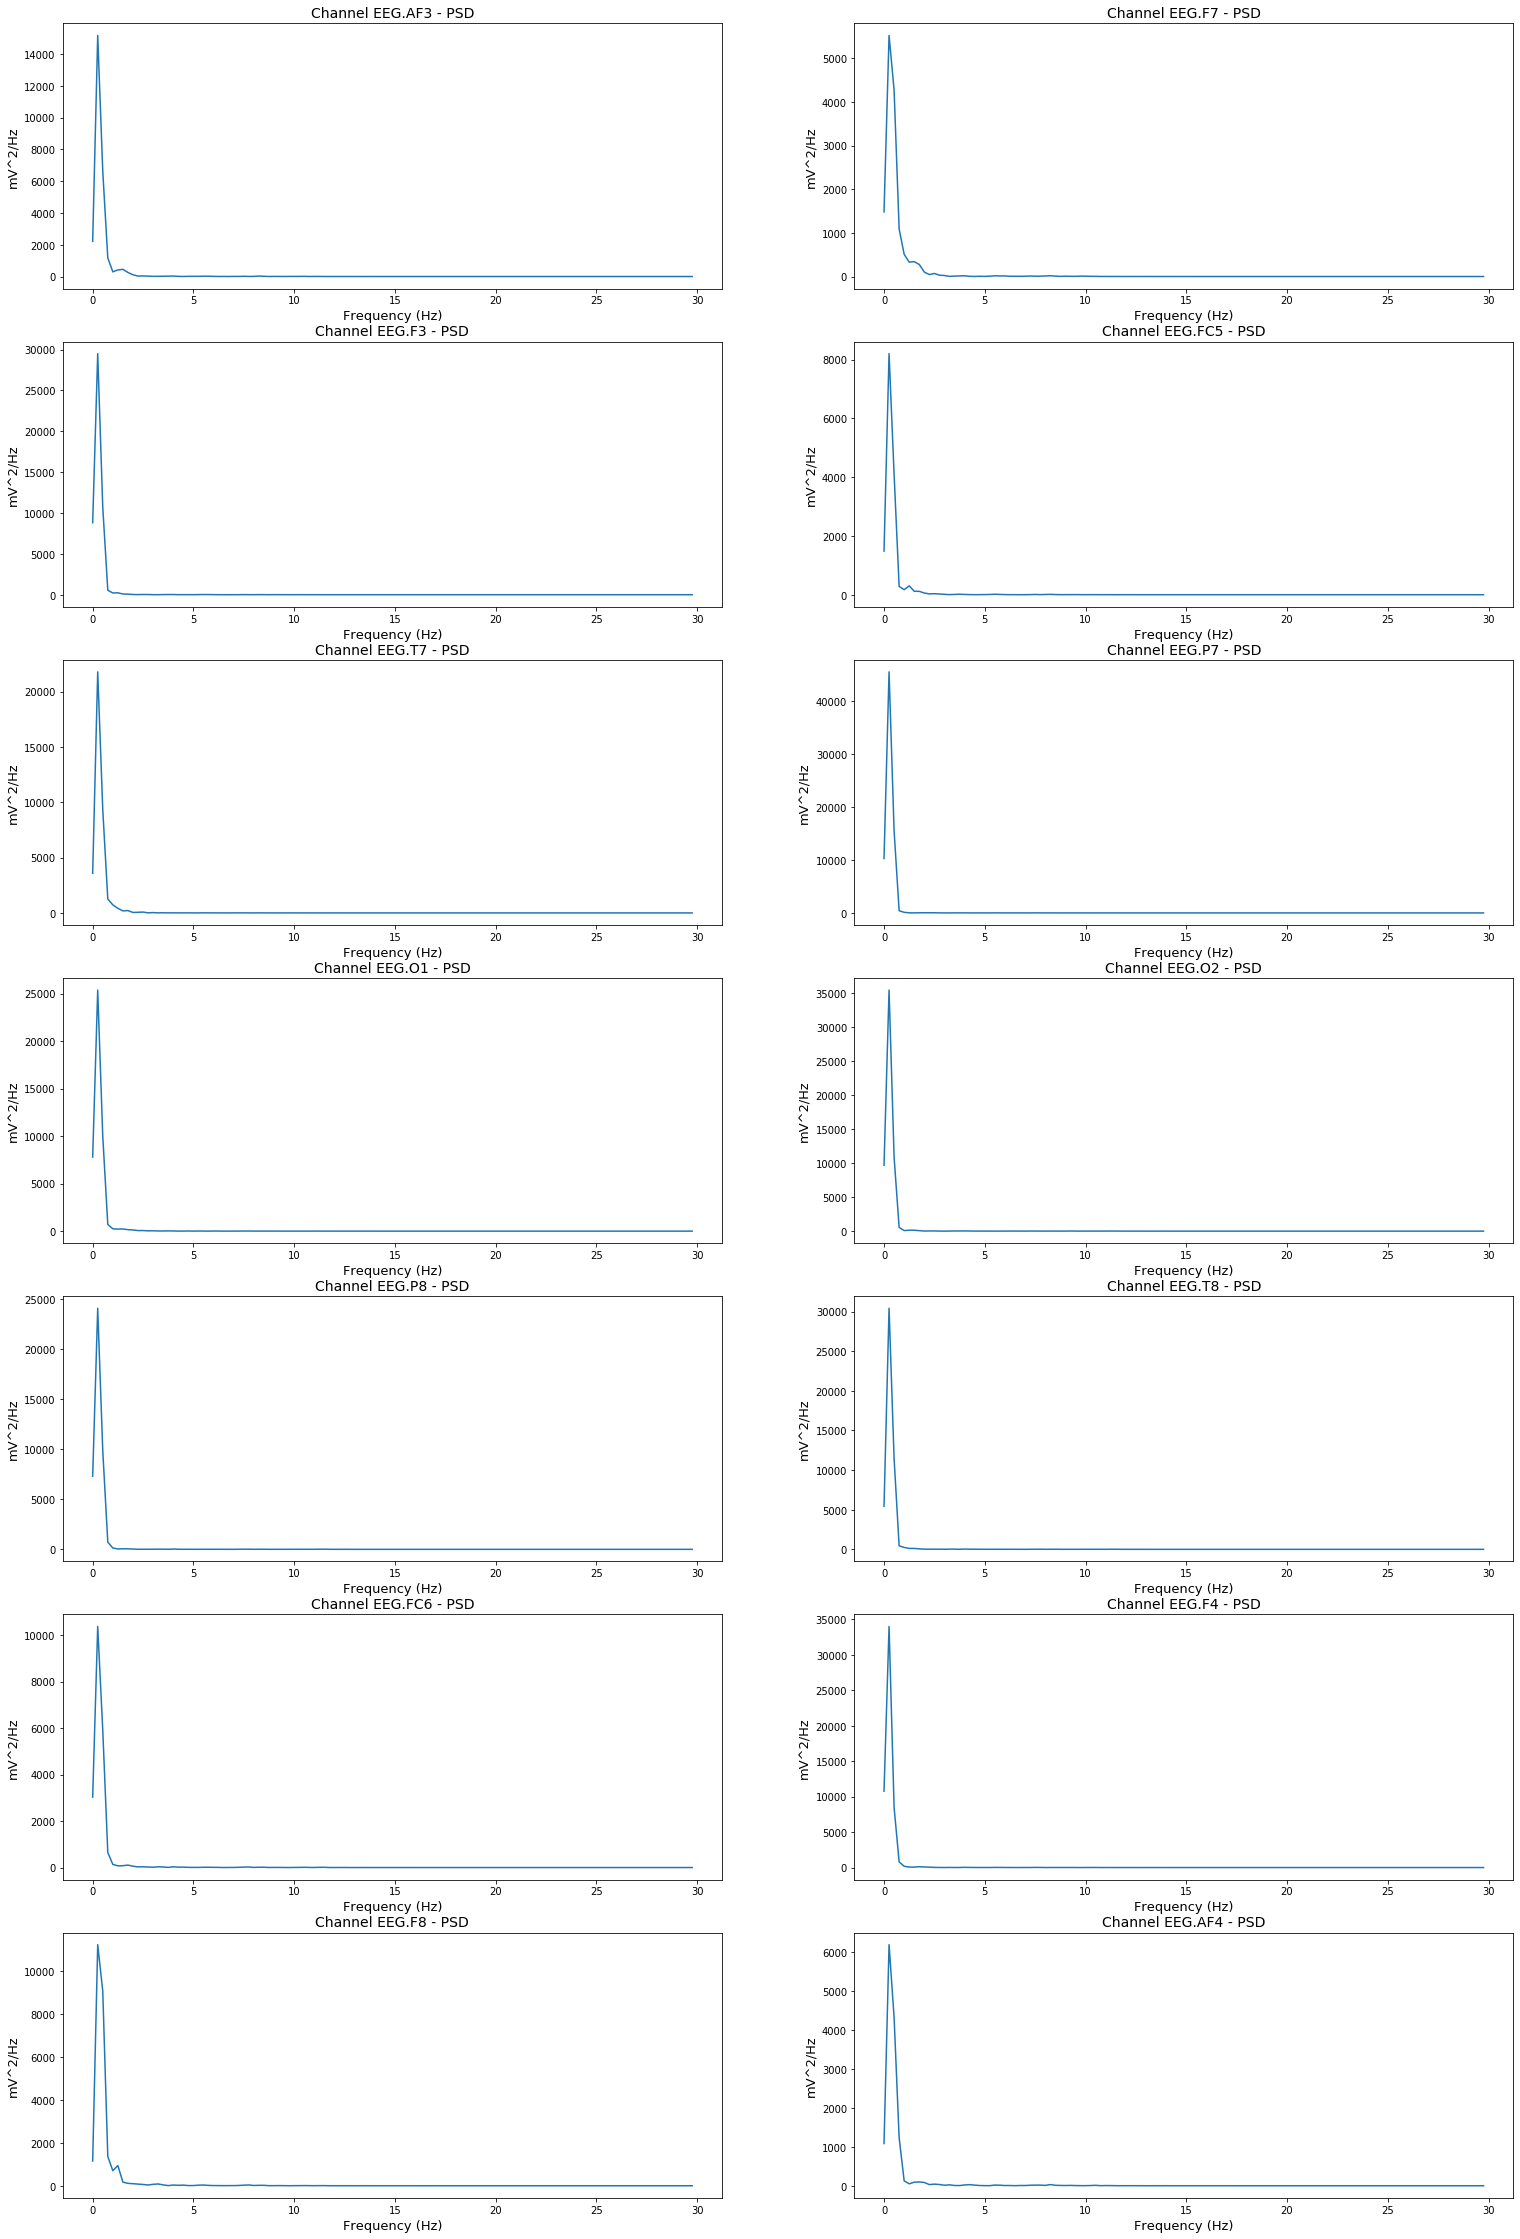

In [145]:
%%time
plot_psd(open_filtered, cols=2, max_f=30, figsize=(26,40), unit="mV^2/Hz")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning:

invalid value encountered in true_divide



CPU times: user 232 ms, sys: 984 µs, total: 233 ms
Wall time: 231 ms


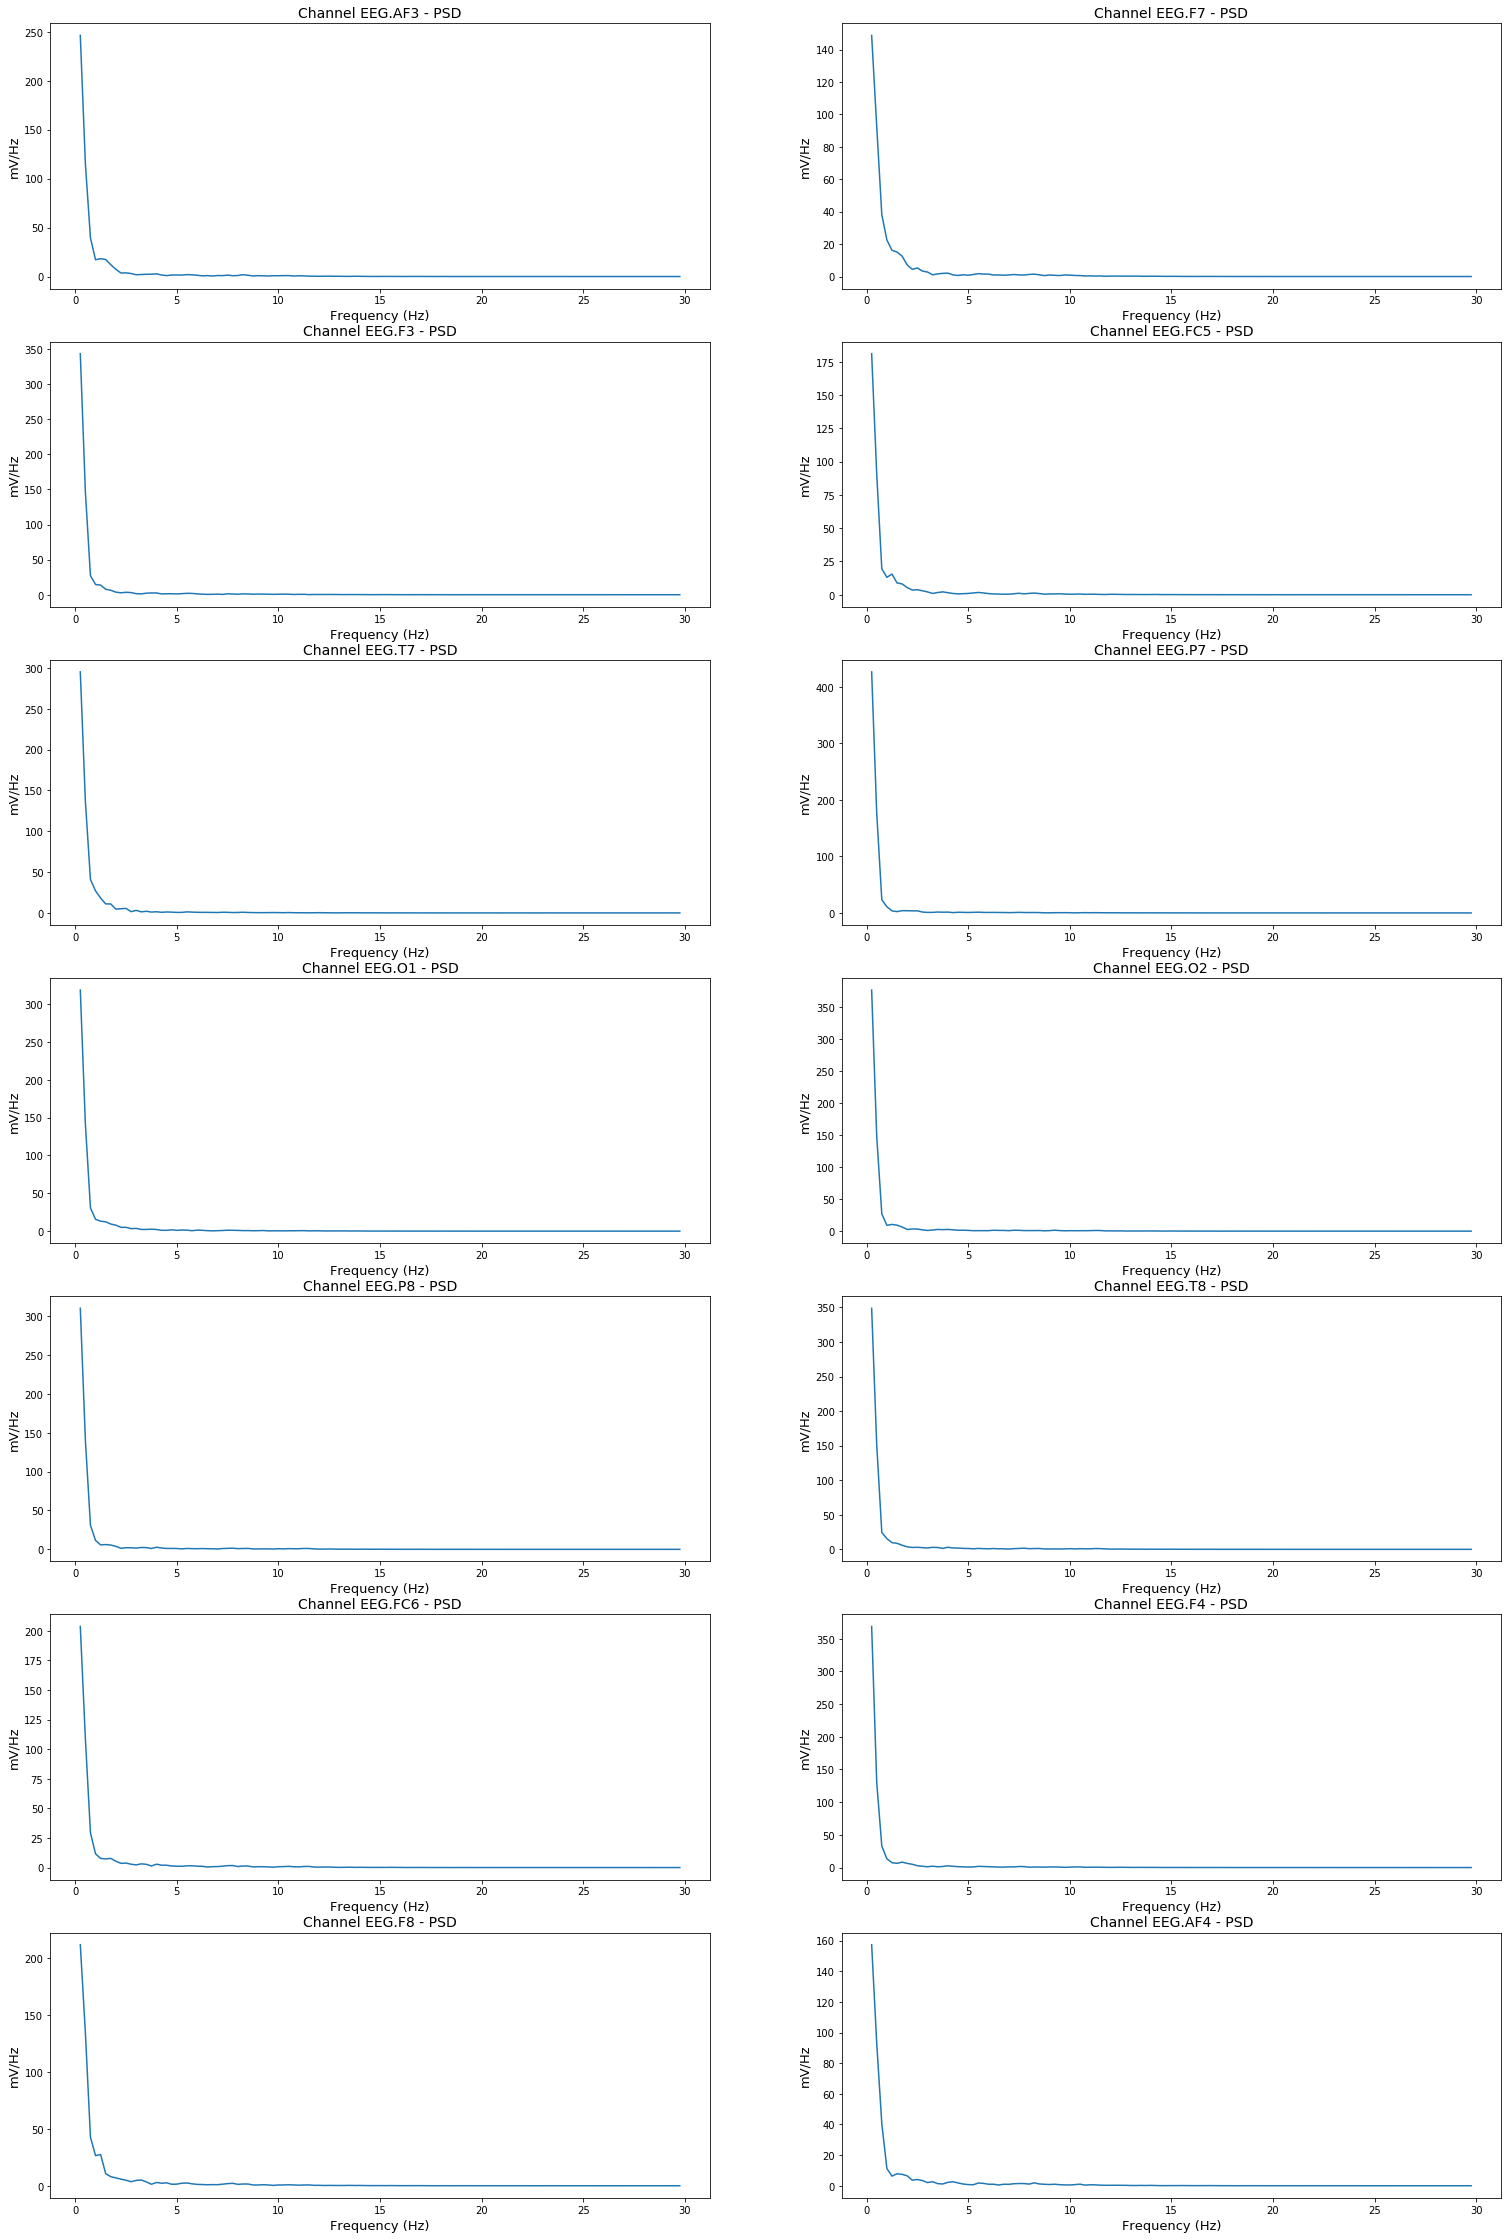

In [146]:
%%time
plot_psd(open_filtered, cols=2, max_f=30, figsize=(26,40), unit="mV/Hz")

#### Close

CPU times: user 233 ms, sys: 2.82 ms, total: 236 ms
Wall time: 238 ms


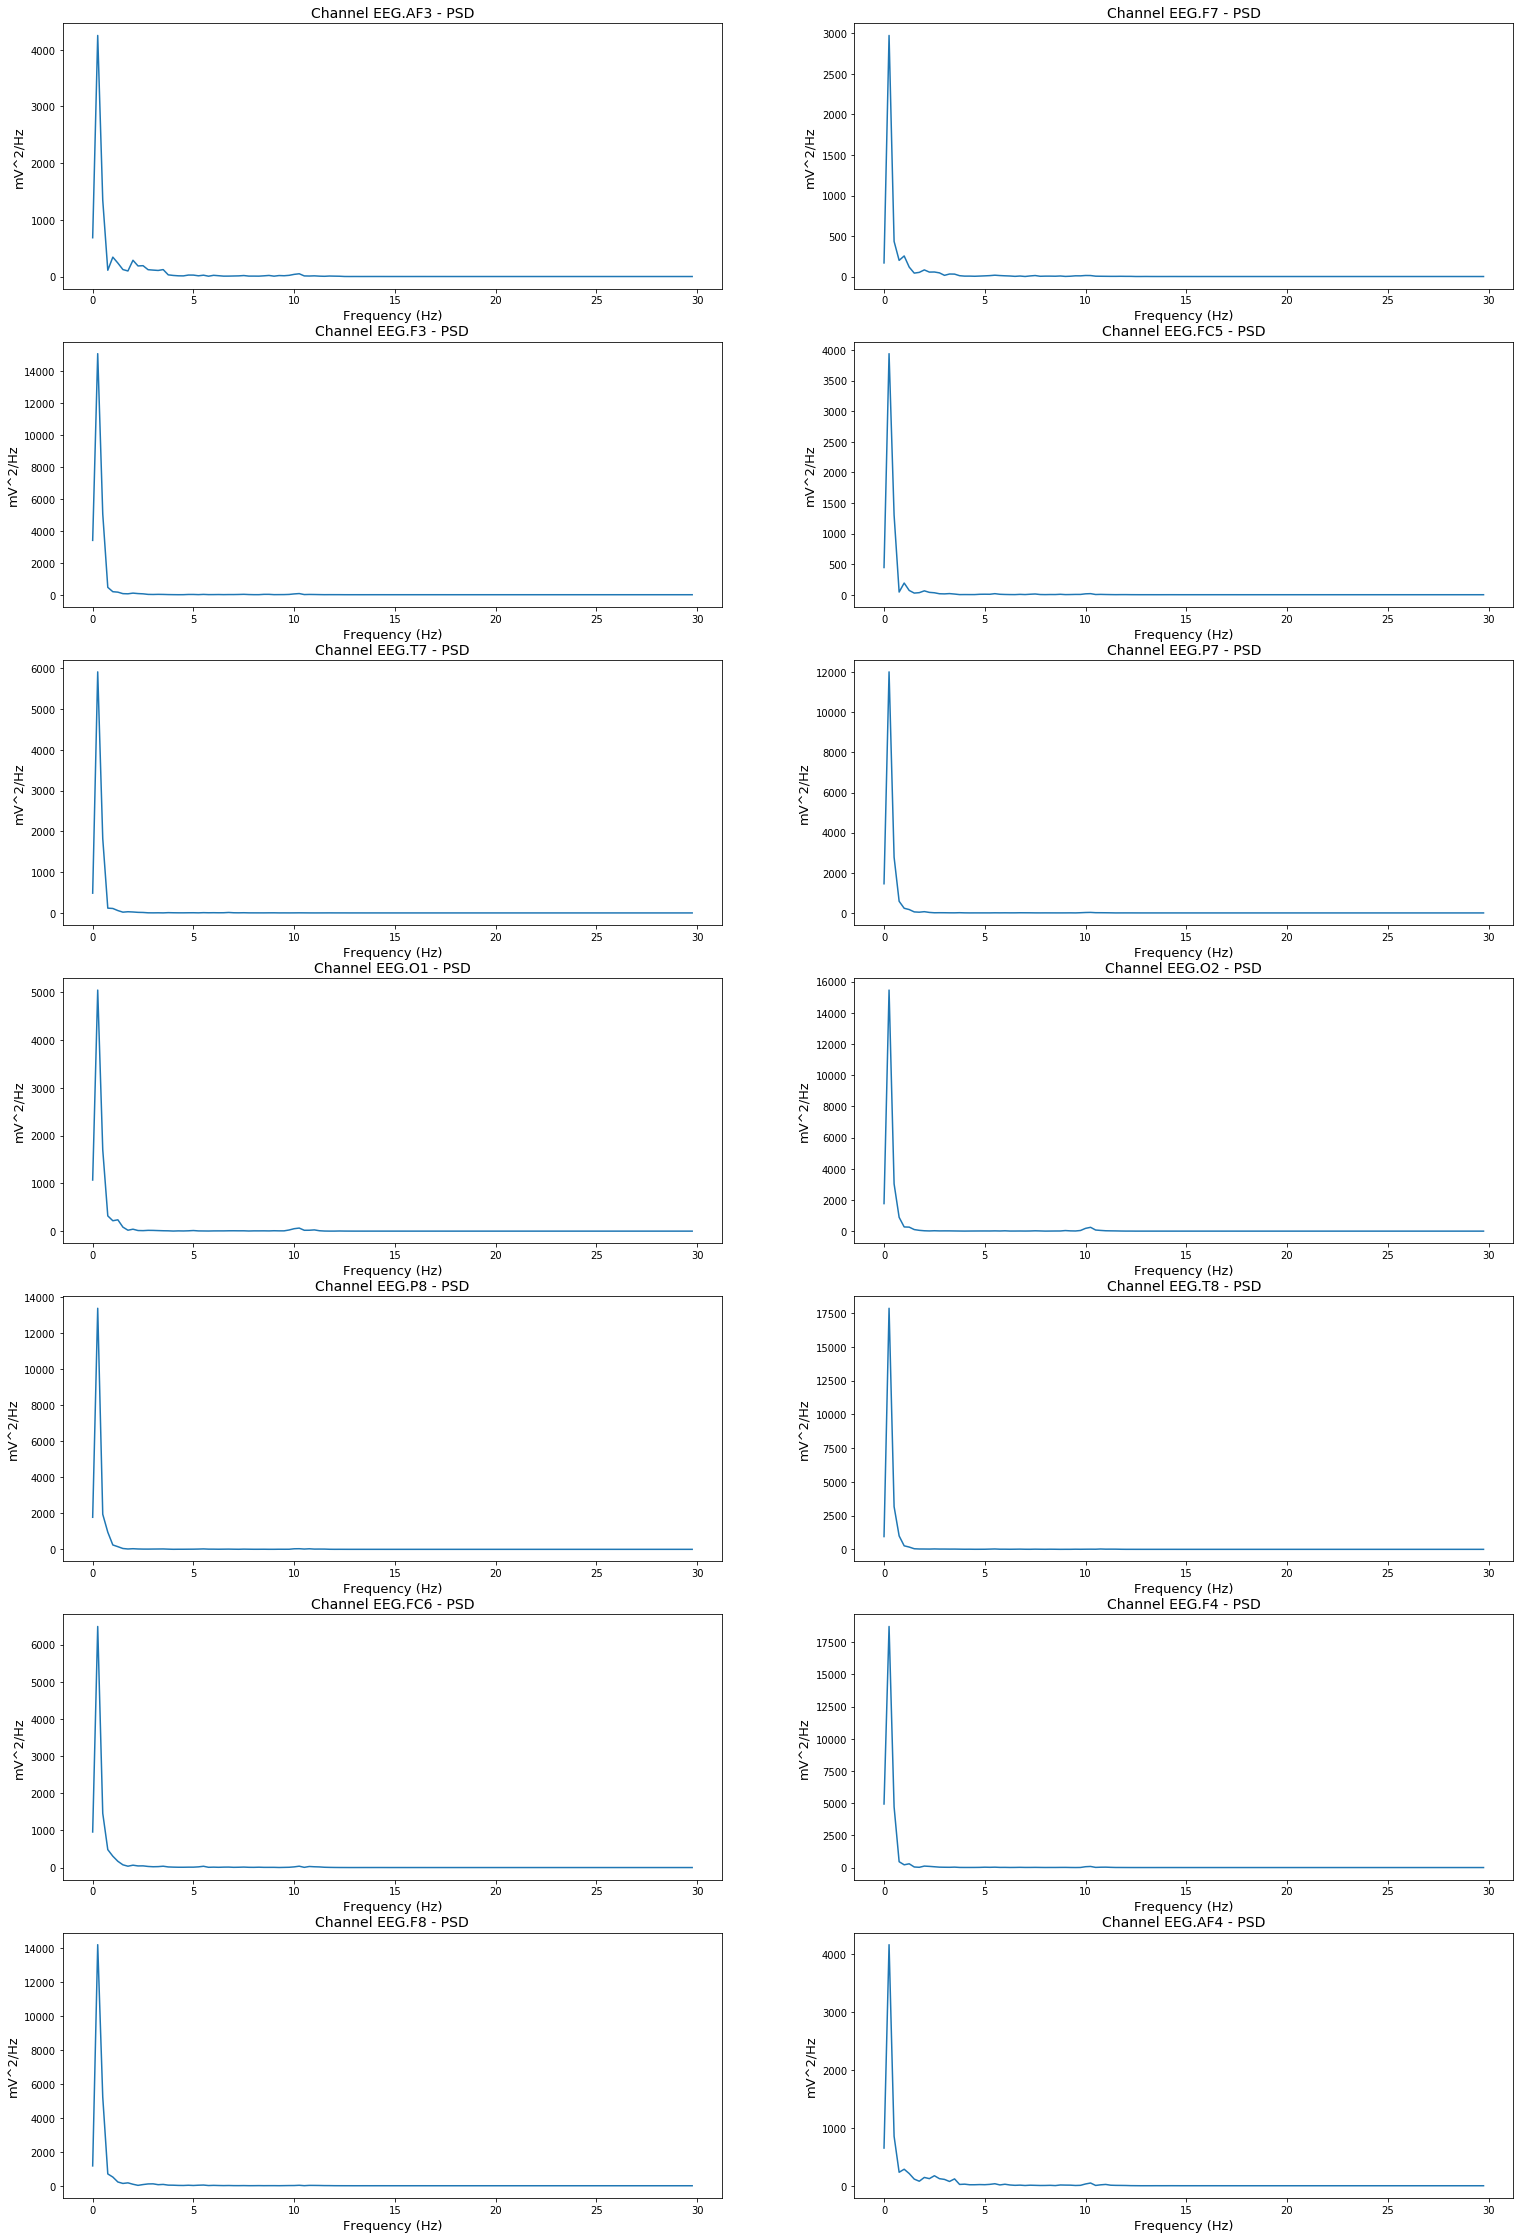

In [147]:
%%time
plot_psd(close_filtered, cols=2, max_f=30, figsize=(26,40), unit="mV^2/Hz")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning:

invalid value encountered in true_divide



CPU times: user 227 ms, sys: 0 ns, total: 227 ms
Wall time: 228 ms


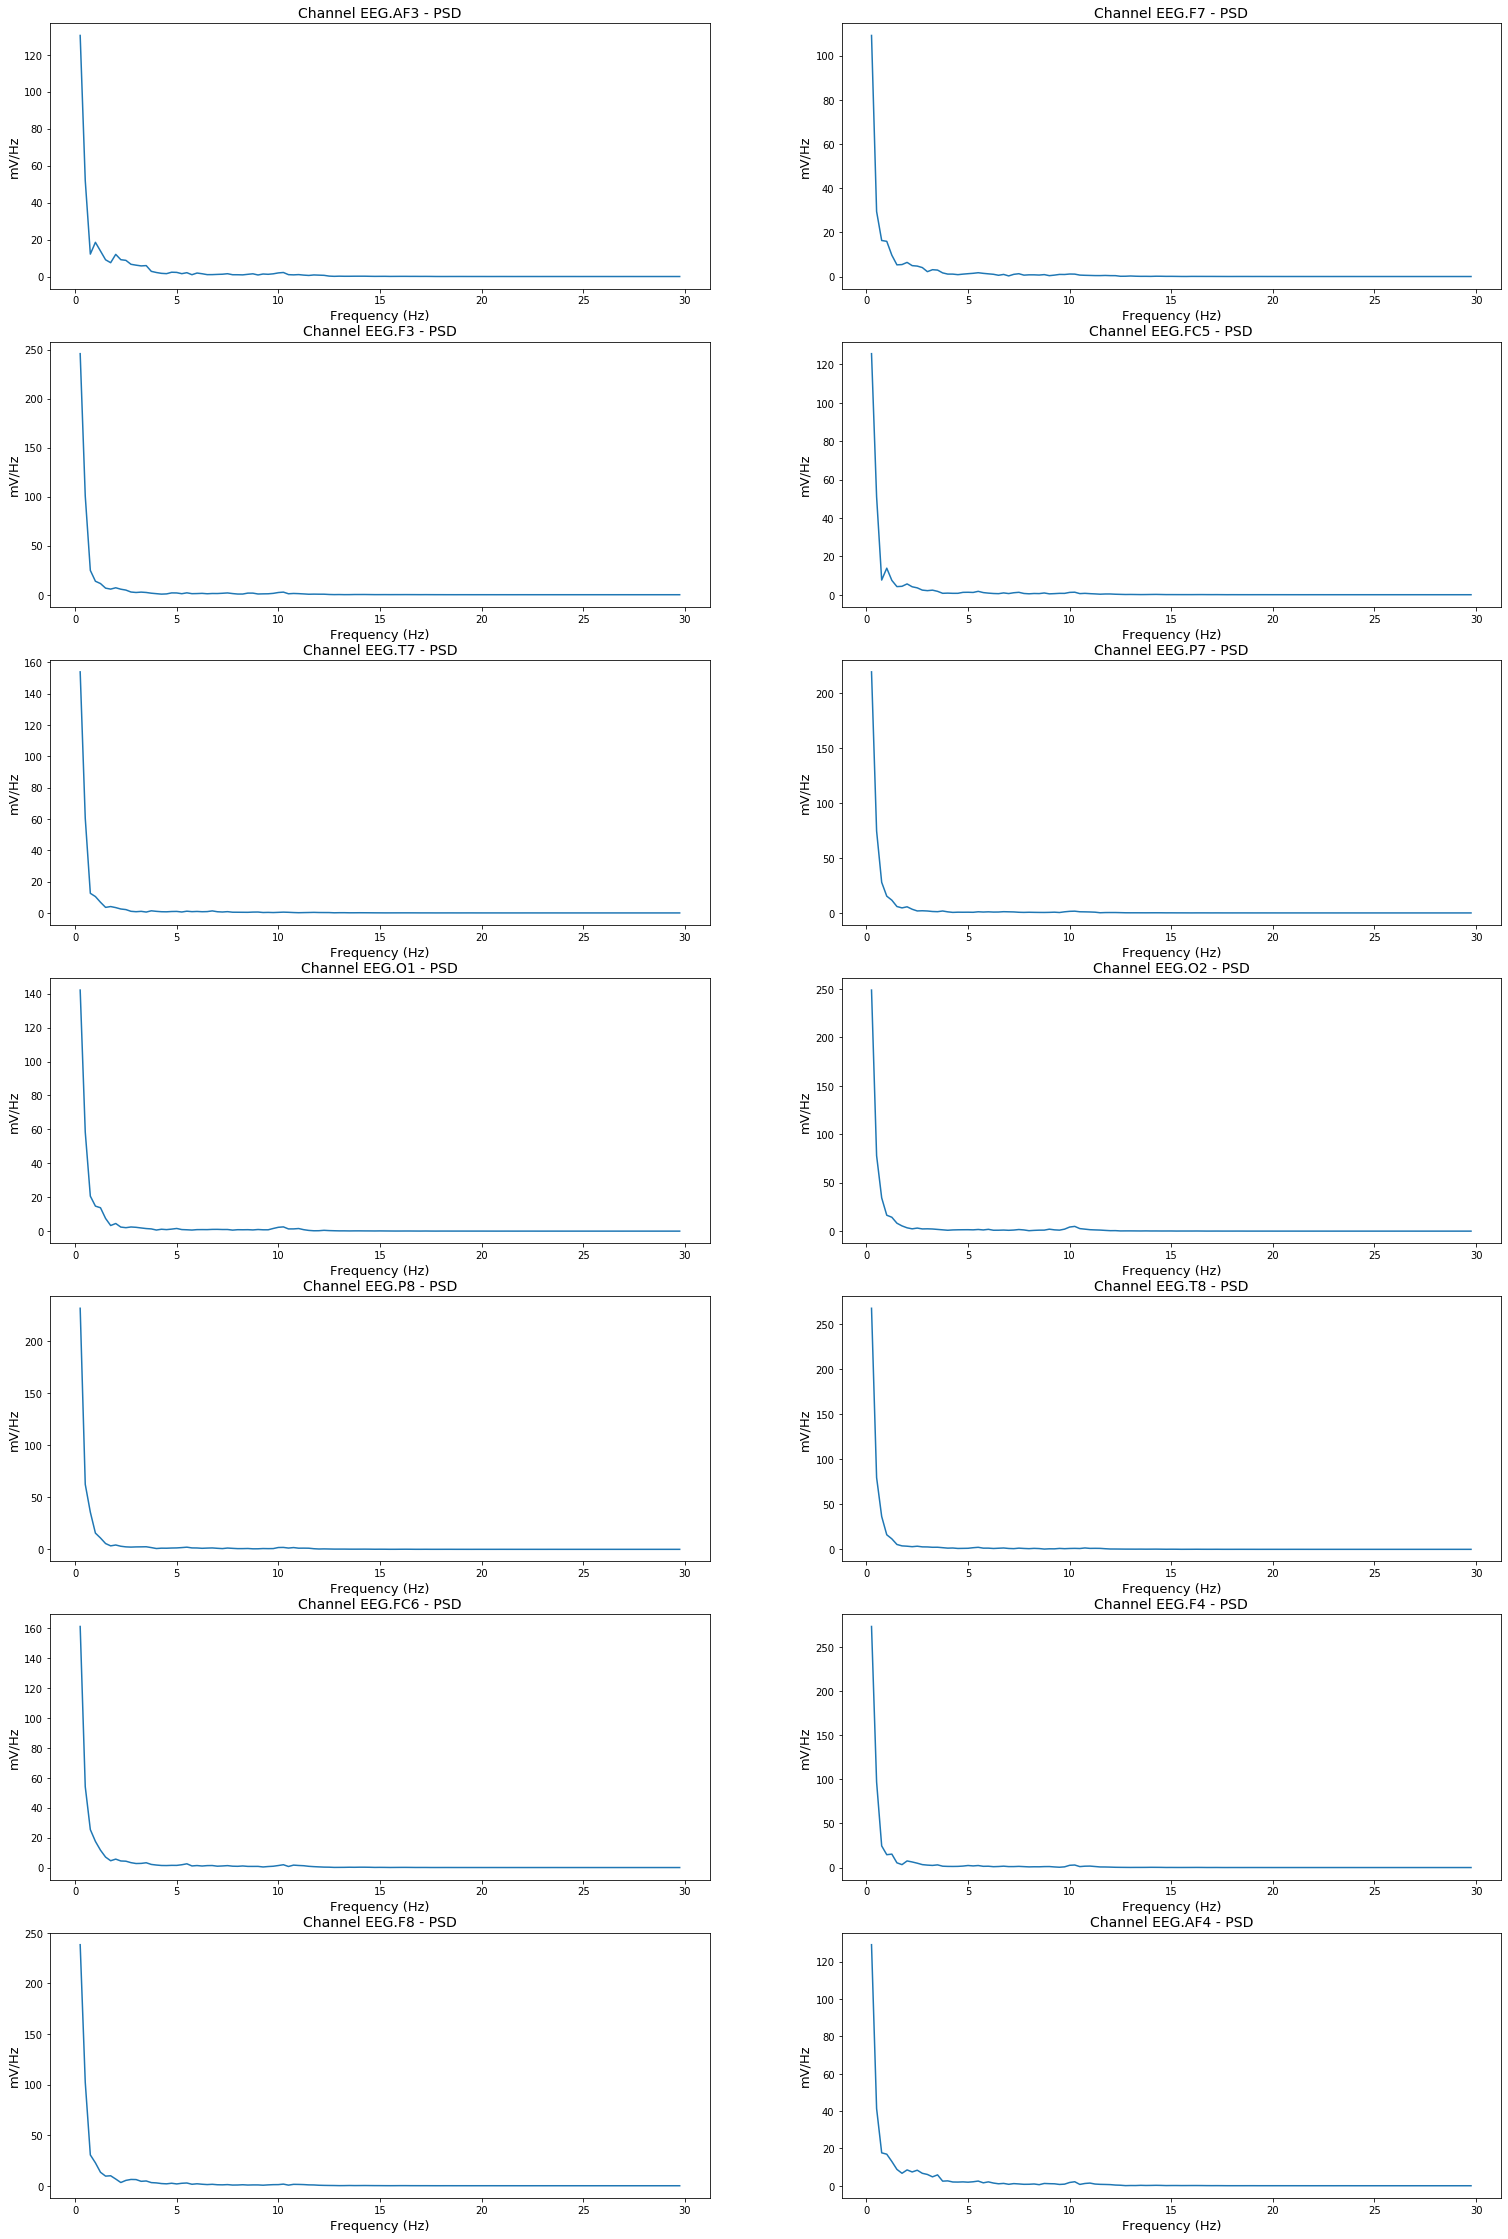

In [148]:
%%time
plot_psd(close_filtered, cols=2, max_f=30, figsize=(26,40), unit="mV/Hz")